In [61]:
"""Produce histogram of discriminant from tagger output and labels."""
from __future__ import annotations

import numpy as np
import pandas as pd
from ftag import Flavours
from ftag import Cuts
from ftag.hdf5 import H5Reader

from puma import Histogram, HistogramPlot
from puma.utils import get_good_linestyles
from puma.metrics import calc_rej
from puma import Roc, RocPlot

In [62]:
! pip install --upgrade numpy==1.26.4

In [63]:
# general functions
def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant.

    Parameters
    ----------
    arr : numpy.ndarray
        array with with shape (, 2)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    return np.log(arr[1] / arr[0])

# general functions
def disc_fct_3cl(arr: np.ndarray, fc: float = 0.4) -> np.ndarray:
    """Tagger discriminant.

    Parameters
    ----------
    arr : numpy.ndarray
        Array with shape (, 2)

    fc : float, optional
        Factor coefficient, by default 0.1

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    return np.log(arr[2] / (fc * arr[0] + (1. - fc) * arr[1]))

## Muon

### Run 2 result

In [64]:
fname = "data/2024-10-07/run2/user.emaricic.41130479._000189.output.h5"
reader = H5Reader(fname, batch_size=100_000, jets_name="muons")
cuts = Cuts.from_list(["pt > 10e3"])
data = reader.load({"muons": None}, num_jets=1_500_000)
idx, muons = cuts(data["muons"])
tagger = "PLIT_TPLTmu"
tagger_plivr21 = "PromptLeptonImprovedVeto"

In [65]:
! h5ls -v data/2024-10-07/run2/user.emaricic.41130479._000189.output.h5/muons

Opened "data/2024-10-07/run2/user.emaricic.41130479._000189.output.h5" with sec2 driver.
muons                    Dataset {402690/Inf}
    Location:  1:7432
    Links:     1
    Chunks:    {2048} 299008 bytes
    Storage:   58792740 logical bytes, 39938436 allocated bytes, 147.21% utilization
    Filter-0:  deflate-1 OPT {7}
    Type:      struct {
                   "pt"               +0    native float
                   "eta"              +4    native float
                   "absEta"           +8    native float
                   "phi"              +12   native float
                   "pt_track"         +16   native float
                   "eta_track"        +20   native float
                   "absEta_track"     +24   native float
                   "phi_track"        +28   native float
                   "truth_pt"         +32   native float
                   "truth_eta"        +36   native float
                   "truth_absEta"     +40   native float
                   "tr

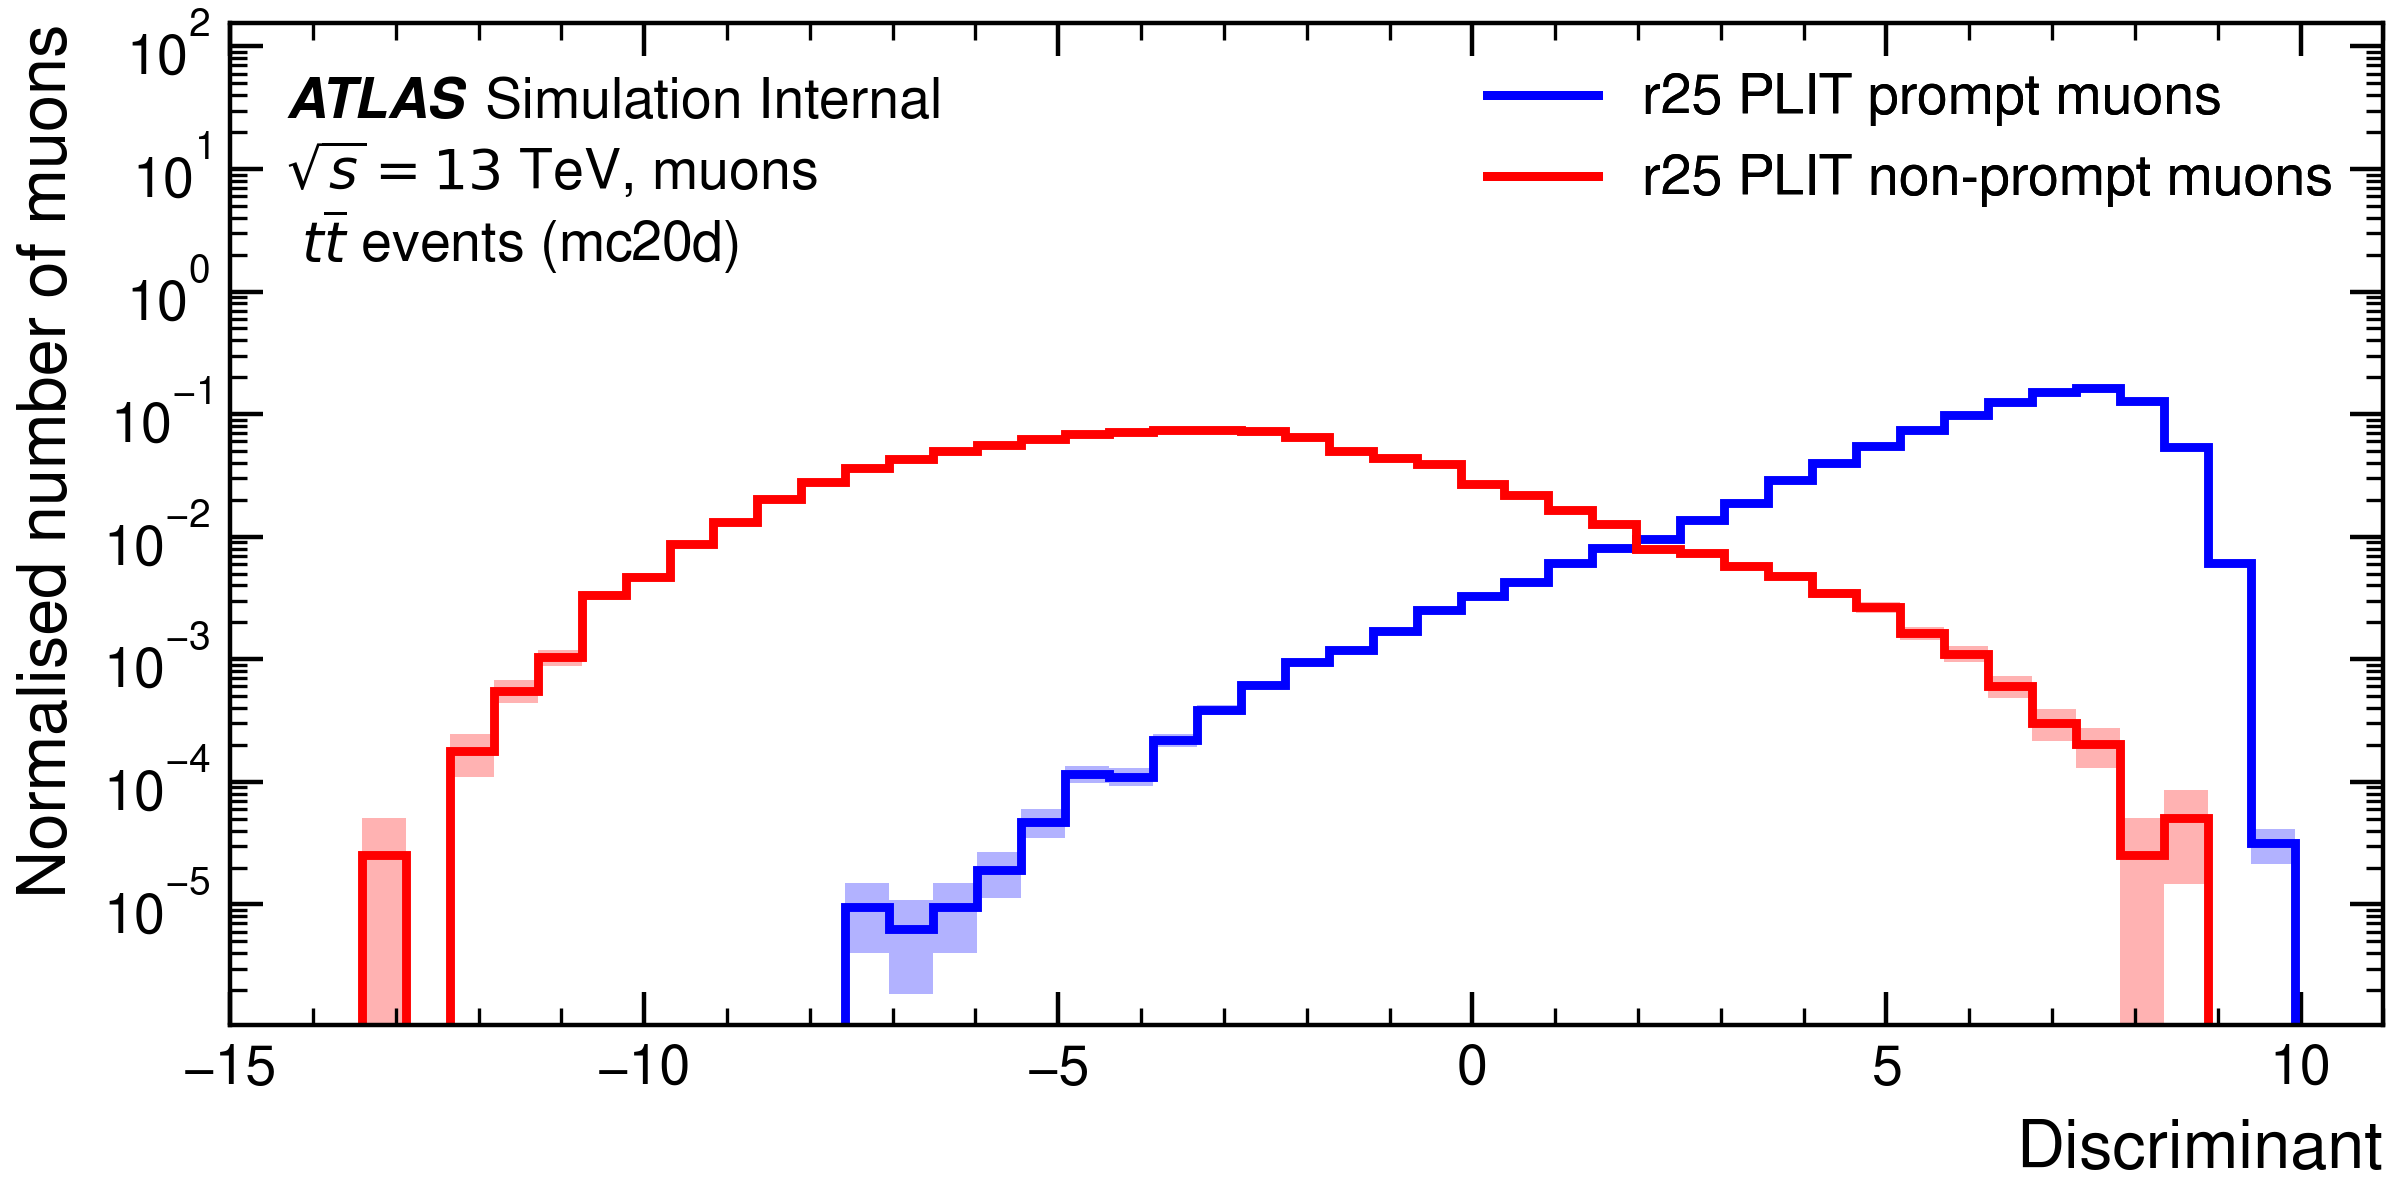

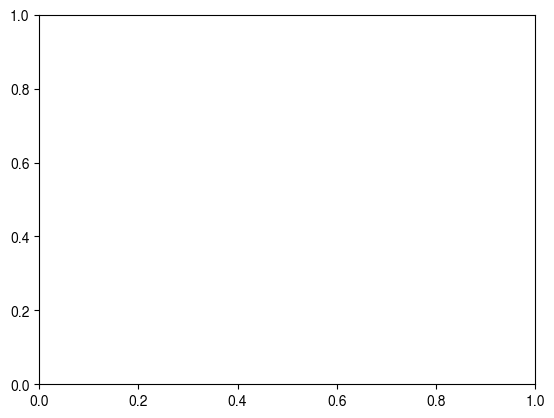

In [66]:
# Calculate discriminant score
df = pd.DataFrame(muons)
df[f"disc_{tagger}"] = np.log(
    df[f"{tagger}_pmuxpromp"] / (df[f"{tagger}_pnpxall"])
)

# defining boolean arrays to select the different flavour classes
is_prompt = df["iffClass"] == 4
is_nonprompt = df["iffClass"] != 4

# Initialise histogram plot
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of muons",
    xlabel=f"Discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-15, 11, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13$ TeV, muons\n $t\overline{t}$ events (mc20d)",
)

# Add the histograms
plot_histo.add(
    Histogram(
        df[is_prompt][f"disc_{tagger}"],
        label="r25 PLIT prompt muons",
        colour="blue",
        linestyle="-",
    ),
)
plot_histo.add(
    Histogram(
        df[is_nonprompt][f"disc_{tagger}"],
        label="r25 PLIT non-prompt muons",
        colour="red",
        linestyle="-",
    )
)

plot_histo.draw()
plot_histo.savefig("histogram_discriminant_mc20d_r25_plit_muon.png", transparent=False)
from IPython.display import Image
Image("histogram_discriminant_mc20d_r25_plit_muon.png")

In [ ]:
# use uproot to create root file with discriminant histogram
import uproot
from hist import Hist

root_file = uproot.recreate("demo_uproot_file.root")

h_disc_prompt = (
    Hist.new.Reg(50, -15, 11, name="discriminant", label="PLIT discriminant")
    .Double()
)
h_disc_prompt.fill(discriminant=df[is_prompt][f"disc_{tagger}"])
root_file["h_plit_muon_run2_disc_prompt"] = h_disc_prompt.to_numpy()


h_disc_nonprompt = (
    Hist.new.Reg(50, -15, 11, name="discriminant", label="PLIT discriminant")
    .Double()
)
h_disc_nonprompt.fill(discriminant=df[is_nonprompt][f"disc_{tagger}"])
root_file["h_plit_muon_run2_disc_nonprompt"] = h_disc_nonprompt.to_numpy()

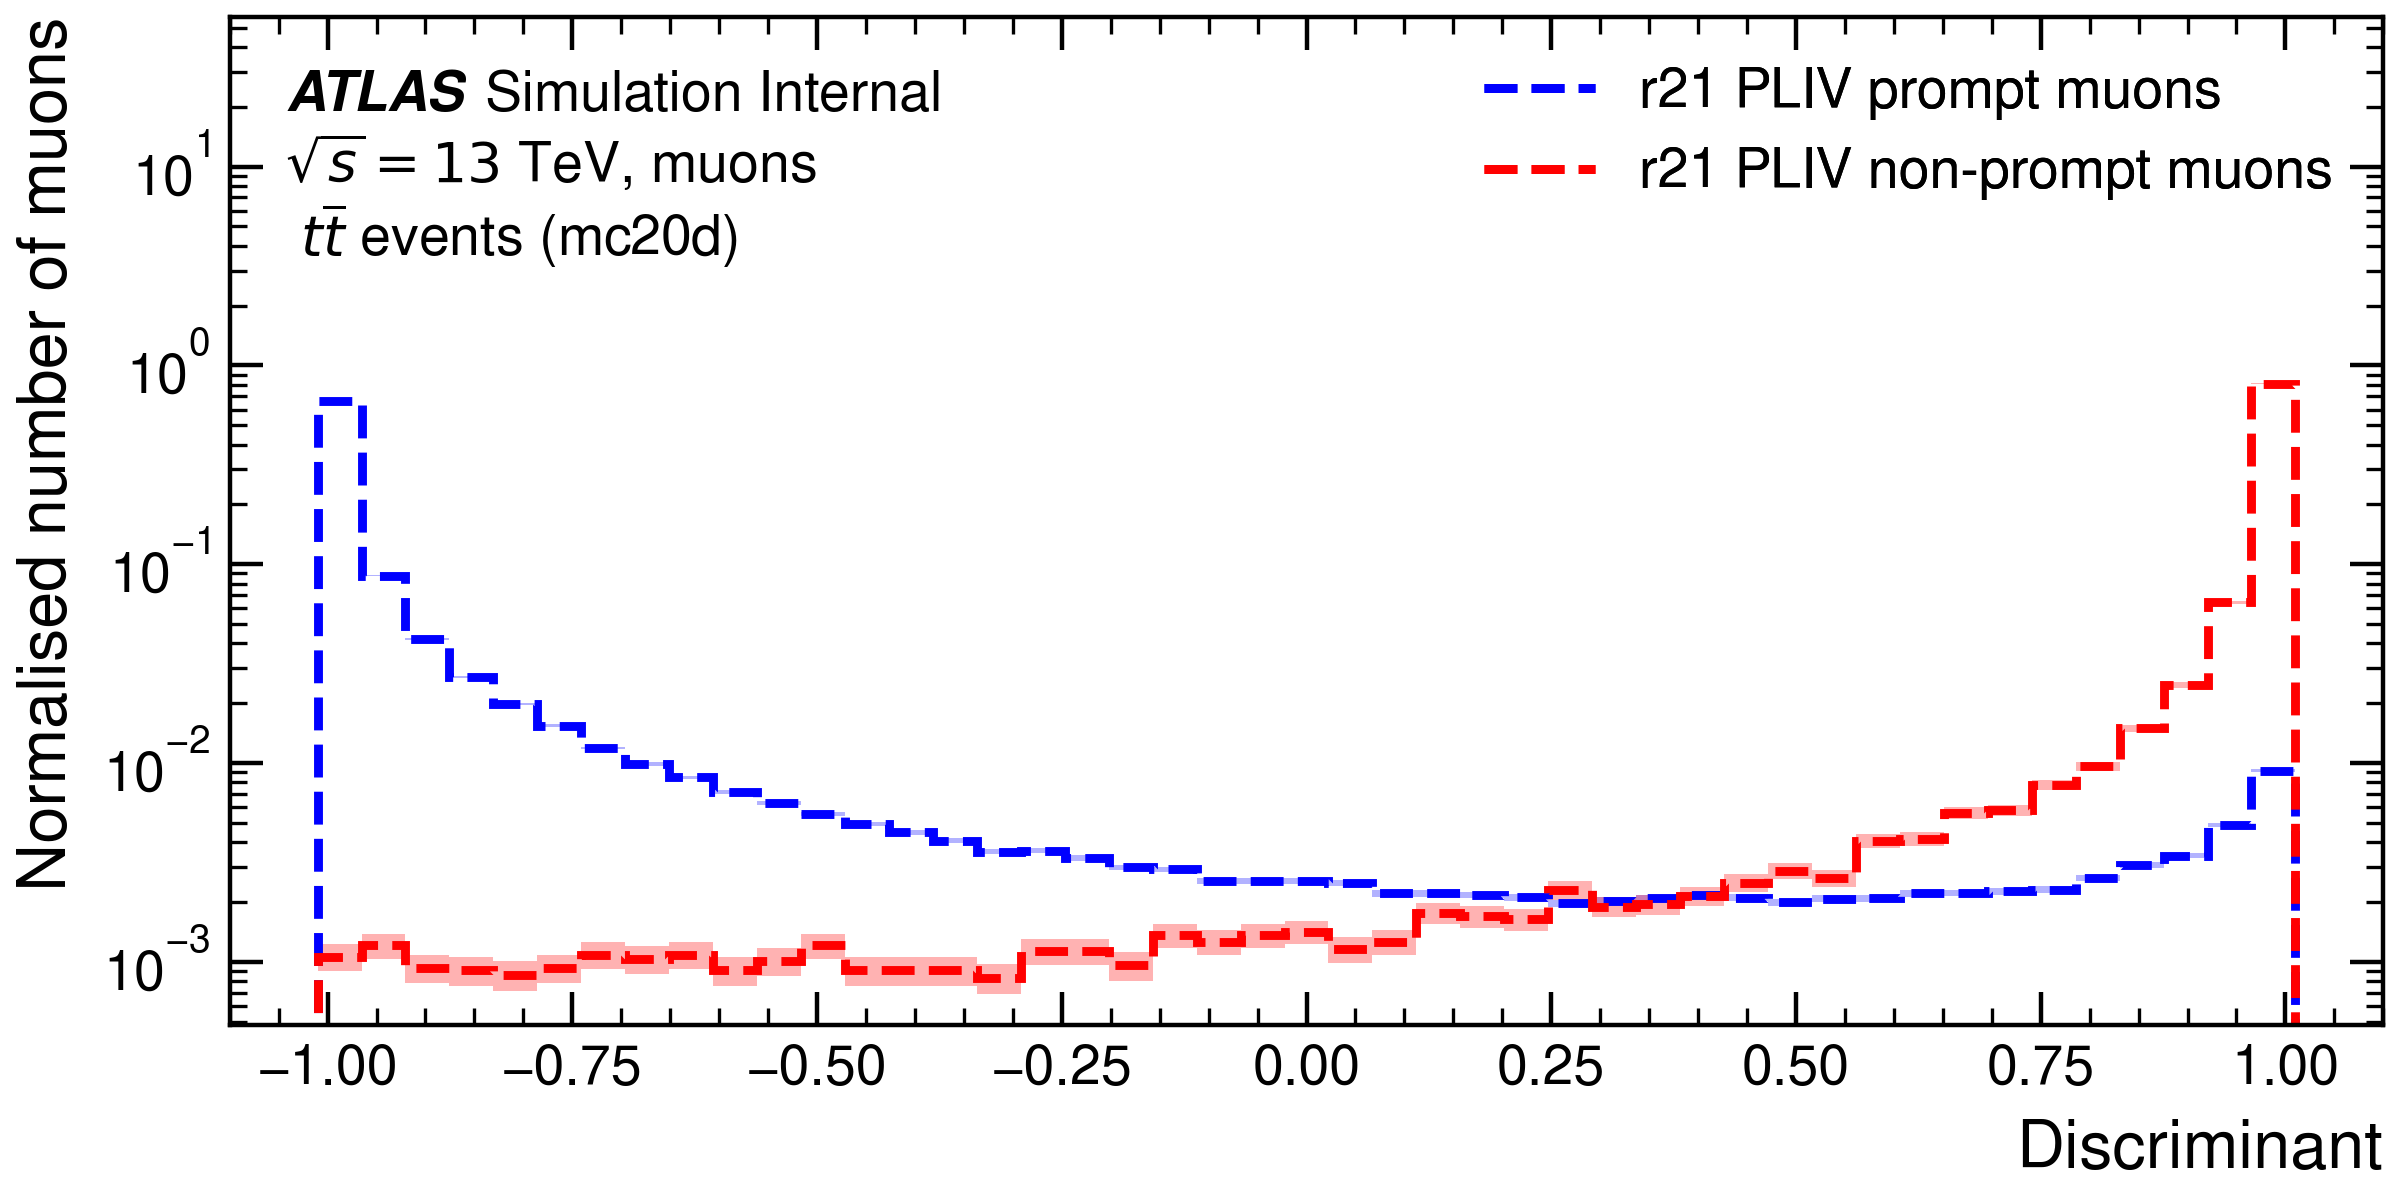

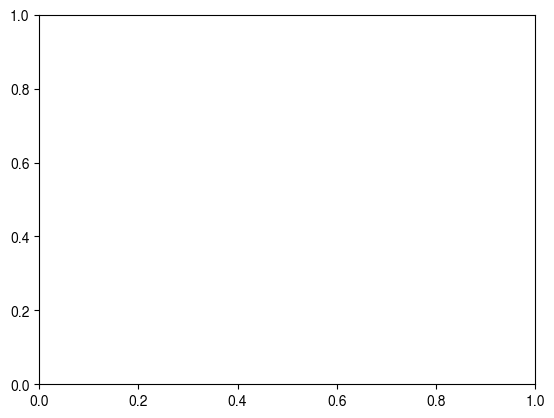

In [67]:
# Calculate discriminant score
df = pd.DataFrame(muons)
df[f"disc_{tagger}"] = np.log(
    df[f"{tagger}_pmuxpromp"] / (df[f"{tagger}_pnpxall"])
)

# defining boolean arrays to select the different flavour classes
is_prompt = df["iffClass"] == 4
is_nonprompt = df["iffClass"] != 4

# Initialise histogram plot
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of muons",
    xlabel=f"Discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-1.1, 1.1, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13$ TeV, muons\n $t\overline{t}$ events (mc20d)",
)

# Add the histograms
plot_histo.add(
    Histogram(
        df[is_prompt][tagger_plivr21],
        label="r21 PLIV prompt muons",
        colour="blue",
        linestyle="--",
    ),
)
plot_histo.add(
    Histogram(
        df[is_nonprompt][tagger_plivr21],
        label="r21 PLIV non-prompt muons",
        colour="red",
        linestyle="--",
    )
)

plot_histo.draw()
plot_histo.savefig("histogram_discriminant_mc20d_r21_pliv_muon.png", transparent=False)
from IPython.display import Image
Image("histogram_discriminant_mc20d_r21_pliv_muon.png")

In [ ]:
# use uproot to create root file with discriminant histogram
h_disc_prompt = (
    Hist.new.Reg(50, -1.1, 1.1, name="discriminant", label="PLIV discriminant")
    .Double()
)
h_disc_prompt.fill(discriminant=df[is_prompt][tagger_plivr21])
root_file["h_pliv_muon_run2_disc_prompt"] = h_disc_prompt.to_numpy()


h_disc_nonprompt = (
    Hist.new.Reg(50, -1.1, 1.1, name="discriminant", label="PLIV discriminant")
    .Double()
)
h_disc_nonprompt.fill(discriminant=df[is_nonprompt][tagger_plivr21])
root_file["h_pliv_muon_run2_disc_nonprompt"] = h_disc_nonprompt.to_numpy()

r25 485.6222428818921
r21 on mc20 164.26595026675017
r21 digitized from INT note 244.42139729418585


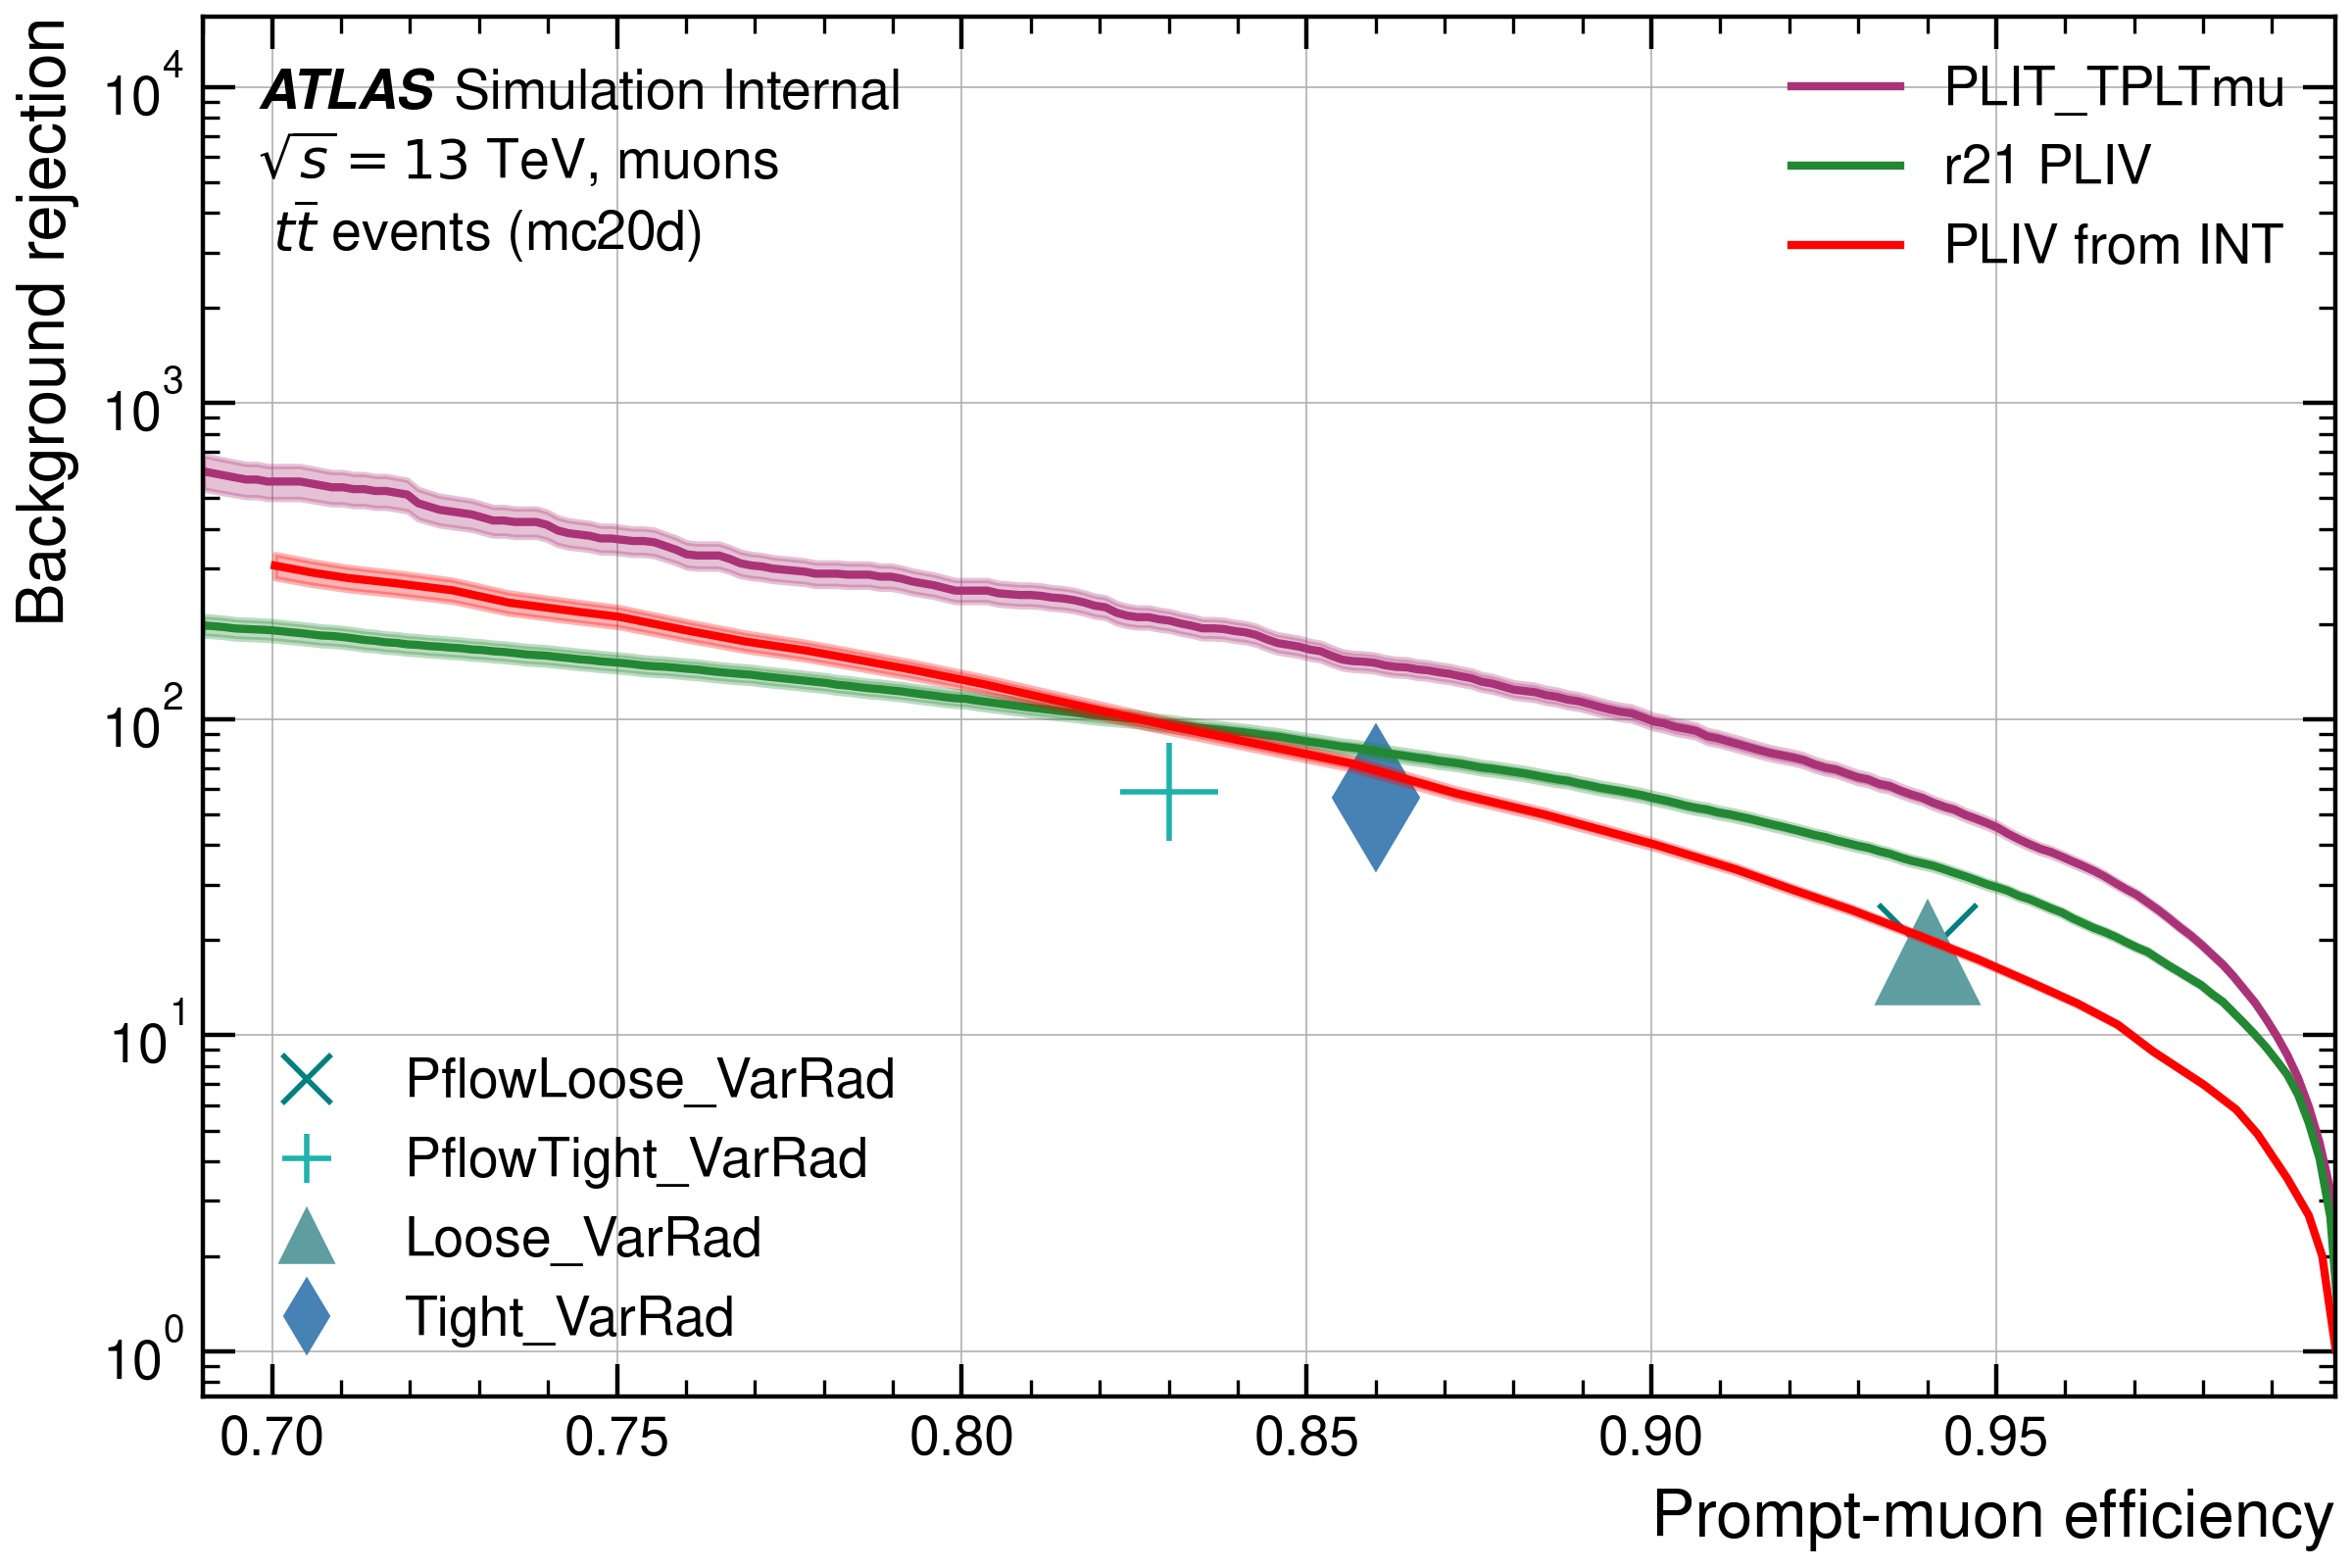

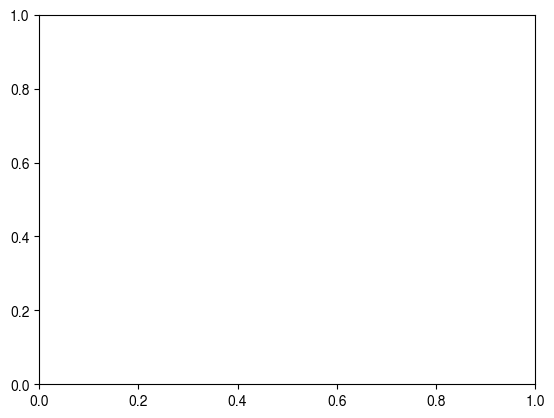

In [68]:
# plot ROC curve
sig_eff = np.linspace(0.69, 1, 200)

n_prompt = sum(is_prompt)
n_nonprompt = sum(is_nonprompt)

# set up ROC plot
plot_roc = RocPlot(
    n_ratio_panels=0,
    ylabel="Background rejection",
    xlabel="Prompt-muon efficiency",
    atlas_second_tag="$\\sqrt{s}=13$ TeV, muons\n $t\overline{t}$ events (mc20d)",
    figsize=(6, 4),
    y_scale=1.4,
)

# add r25 PLIT
discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger}_pnpxall", f"{tagger}_pmuxpromp"]].values
)
nonpromptprompt_rej = calc_rej(discs[is_prompt], discs[is_nonprompt], sig_eff)

plot_roc.add_roc(
    Roc(
        sig_eff,
        nonpromptprompt_rej,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label=tagger,
    ),
    reference=True
)
dx = np.diff(1 - nonpromptprompt_rej)  # Differences in x-values
dy = (sig_eff[:-1] + sig_eff[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r25 " + str(auc))

# add r21 PLIV
discs_pliv_r21 = df[f"{tagger_plivr21}"].values
nonpromptprompt_rej_plivr21 = calc_rej(discs_pliv_r21[is_nonprompt], discs_pliv_r21[is_prompt], sig_eff)

plot_roc.add_roc(
    Roc(
        sig_eff,
        nonpromptprompt_rej_plivr21,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label="r21 PLIV",
    ),
)
dx = np.diff(1 - nonpromptprompt_rej_plivr21)  # Differences in x-values
dy = (sig_eff[:-1] + sig_eff[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r21 on mc20 " + str(auc))

# add r21 PLIV based on numbers from PLIV r21 INT note
epsilon_s = np.array([0.70039012, 0.70585176, 0.71092328, 0.71794538, 0.72613784, 0.7343303, 
 0.74408322, 0.7503251, 0.76046814, 0.7686606, 0.77724317, 0.78582575, 
 0.79284785, 0.8029909, 0.81430429, 0.83029909, 0.84395319, 0.85643693, 
 0.8716515, 0.88452536, 0.90052016, 0.91222367, 0.92080624, 0.9289987, 
 0.93836151, 0.9473342, 0.95552666, 0.96176853, 0.96762029, 0.97269181, 
 0.98010403, 0.98478544, 0.98790637, 0.99219766, 0.9953186, 0.99726918, 
 0.99921977]
)

epsilon_b = np.array([306.28153152, 290.92057772, 279.90758343, 269.31149345, 255.80469993, 
 233.77731929, 219.21456871, 210.91605366, 190.29040894, 176.15596196, 
 165.18263339, 152.91314914, 143.38769108, 129.36569739, 113.75047328, 
 95.00378798, 82.46855933, 72.51410416, 58.27072465, 49.93571962, 
 40.12723597, 33.51405325, 28.72022574, 24.93074951, 20.82202889, 
 17.39044736, 14.52440879, 12.60799273, 10.80455398, 8.90856926, 
 6.97690339, 5.82707247, 4.86673981, 3.52836353, 2.69311493, 2.0033797, 
 1.01315031]
)

plot_roc.add_roc(
    Roc(
        epsilon_s,
        epsilon_b,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label="PLIV from INT",
        colour="red"
    ),
)

dx = np.diff(1 - epsilon_b)  # Differences in x-values
dy = (epsilon_s[:-1] + epsilon_s[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r21 digitized from INT note " + str(auc))

# Markers for working points
working_points = [
    "PflowLoose_VarRad",
    "PflowTight_VarRad",
    "Loose_VarRad",
    "Tight_VarRad",
]
markers = ['x', '+', '^', 'd']
colors = ['#008080', '#20B2AA', '#5F9EA0', '#4682B4']

# List to store handles for the markers
handles = []

for wp, marker, color in zip(working_points, markers, colors):
    # Compute fraction of muons surviving this cut and fraction of background muons being rejected
    prompt_efficiency = sum(muons[is_prompt][wp] == 1) / len(muons[is_prompt])
    nonprompt_rejection = len(muons[is_nonprompt]) / sum(muons[is_nonprompt][wp] == 1)  # rejection is inverse of efficiency

    MARKER_X = round(prompt_efficiency, 2)
    MARKER_Y = round(nonprompt_rejection, 1)

    # Plot the working point marker and save the handle
    handle = plot_roc.axis_top.plot(
        MARKER_X, MARKER_Y, marker=marker, markersize=18, color=color, label=wp, linestyle="None"
    )[0]
    
    # Append the handle to the list for custom legend entries
    handles.append(handle)

# Draw the ROC plot
plot_roc.draw()

# Create custom legend using the handles from the working points and add them to the existing puma legend
plot_roc.axis_top.legend(handles=handles, loc="lower left", fontsize=10, markerscale=0.5, frameon=False)


plot_roc.savefig("roc_muon_mc20d.png", transparent=False)
from IPython.display import Image
Image("roc_muon_mc20d.png")

In [69]:
# compute working points
import numpy as np
import logging
import csv

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logging.getLogger().setLevel(logging.INFO)

def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant.

    Parameters
    ----------
    arr : numpy.ndarray
        array with shape (2,)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    return np.log(arr[1] / arr[0])

# Compute discriminants using the appropriate columns
discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger}_pnpxall", f"{tagger}_pmuxpromp"]].values
)

# Obtain cut values for efficiency working points
cut_values = {}
working_points = [0.8, 0.9, 0.95, 0.99]
for eff_wp in working_points:
    # Using discs to calculate the cut values
    d_b_cutvalue = np.quantile(discs, 1.0 - float(eff_wp))
    # Round cut value to 3 decimals
    cut_values[eff_wp] = round(d_b_cutvalue, 3)

# Log the cut values
logger.info("Determined efficiency working point cut values:")
for eff, cut in cut_values.items():
    logger.info(f"Efficiency: {eff} | discriminant cut value: {cut}")

# Write working points to a CSV text file
csv_filename = "working_points_muon_run2.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Efficiency", "Discriminant Cut Value"])  # Header row
    for eff, cut in cut_values.items():
        writer.writerow([eff, cut])

logger.info(f"Working points have been written to {csv_filename}.")

INFO:__main__:Determined efficiency working point cut values:
INFO:__main__:Efficiency: 0.8 | discriminant cut value: 4.116
INFO:__main__:Efficiency: 0.9 | discriminant cut value: -0.574
INFO:__main__:Efficiency: 0.95 | discriminant cut value: -4.006
INFO:__main__:Efficiency: 0.99 | discriminant cut value: -7.404
INFO:__main__:Working points have been written to working_points_muon_run2.csv.


### Run 3

In [70]:
# user.emaricic.LD_2024_09_10.601589.PhPy8EG_A14_ttbar_hdamp258p75_nonallhadron.e8549_s4159_r15224_p6390_TREE
fname = "data/2024-10-07/run3/user.emaricic.41130500._000081.output.h5"
reader = H5Reader(fname, batch_size=100_000, jets_name="muons")
cuts = Cuts.from_list(["pt > 10e3"])
data = reader.load({"muons": None}, num_jets=1_500_000)
idx, muons = cuts(data["muons"])
tagger = "PLIT_TPLTmu"
tagger_plivr21 = "PromptLeptonImprovedVeto"

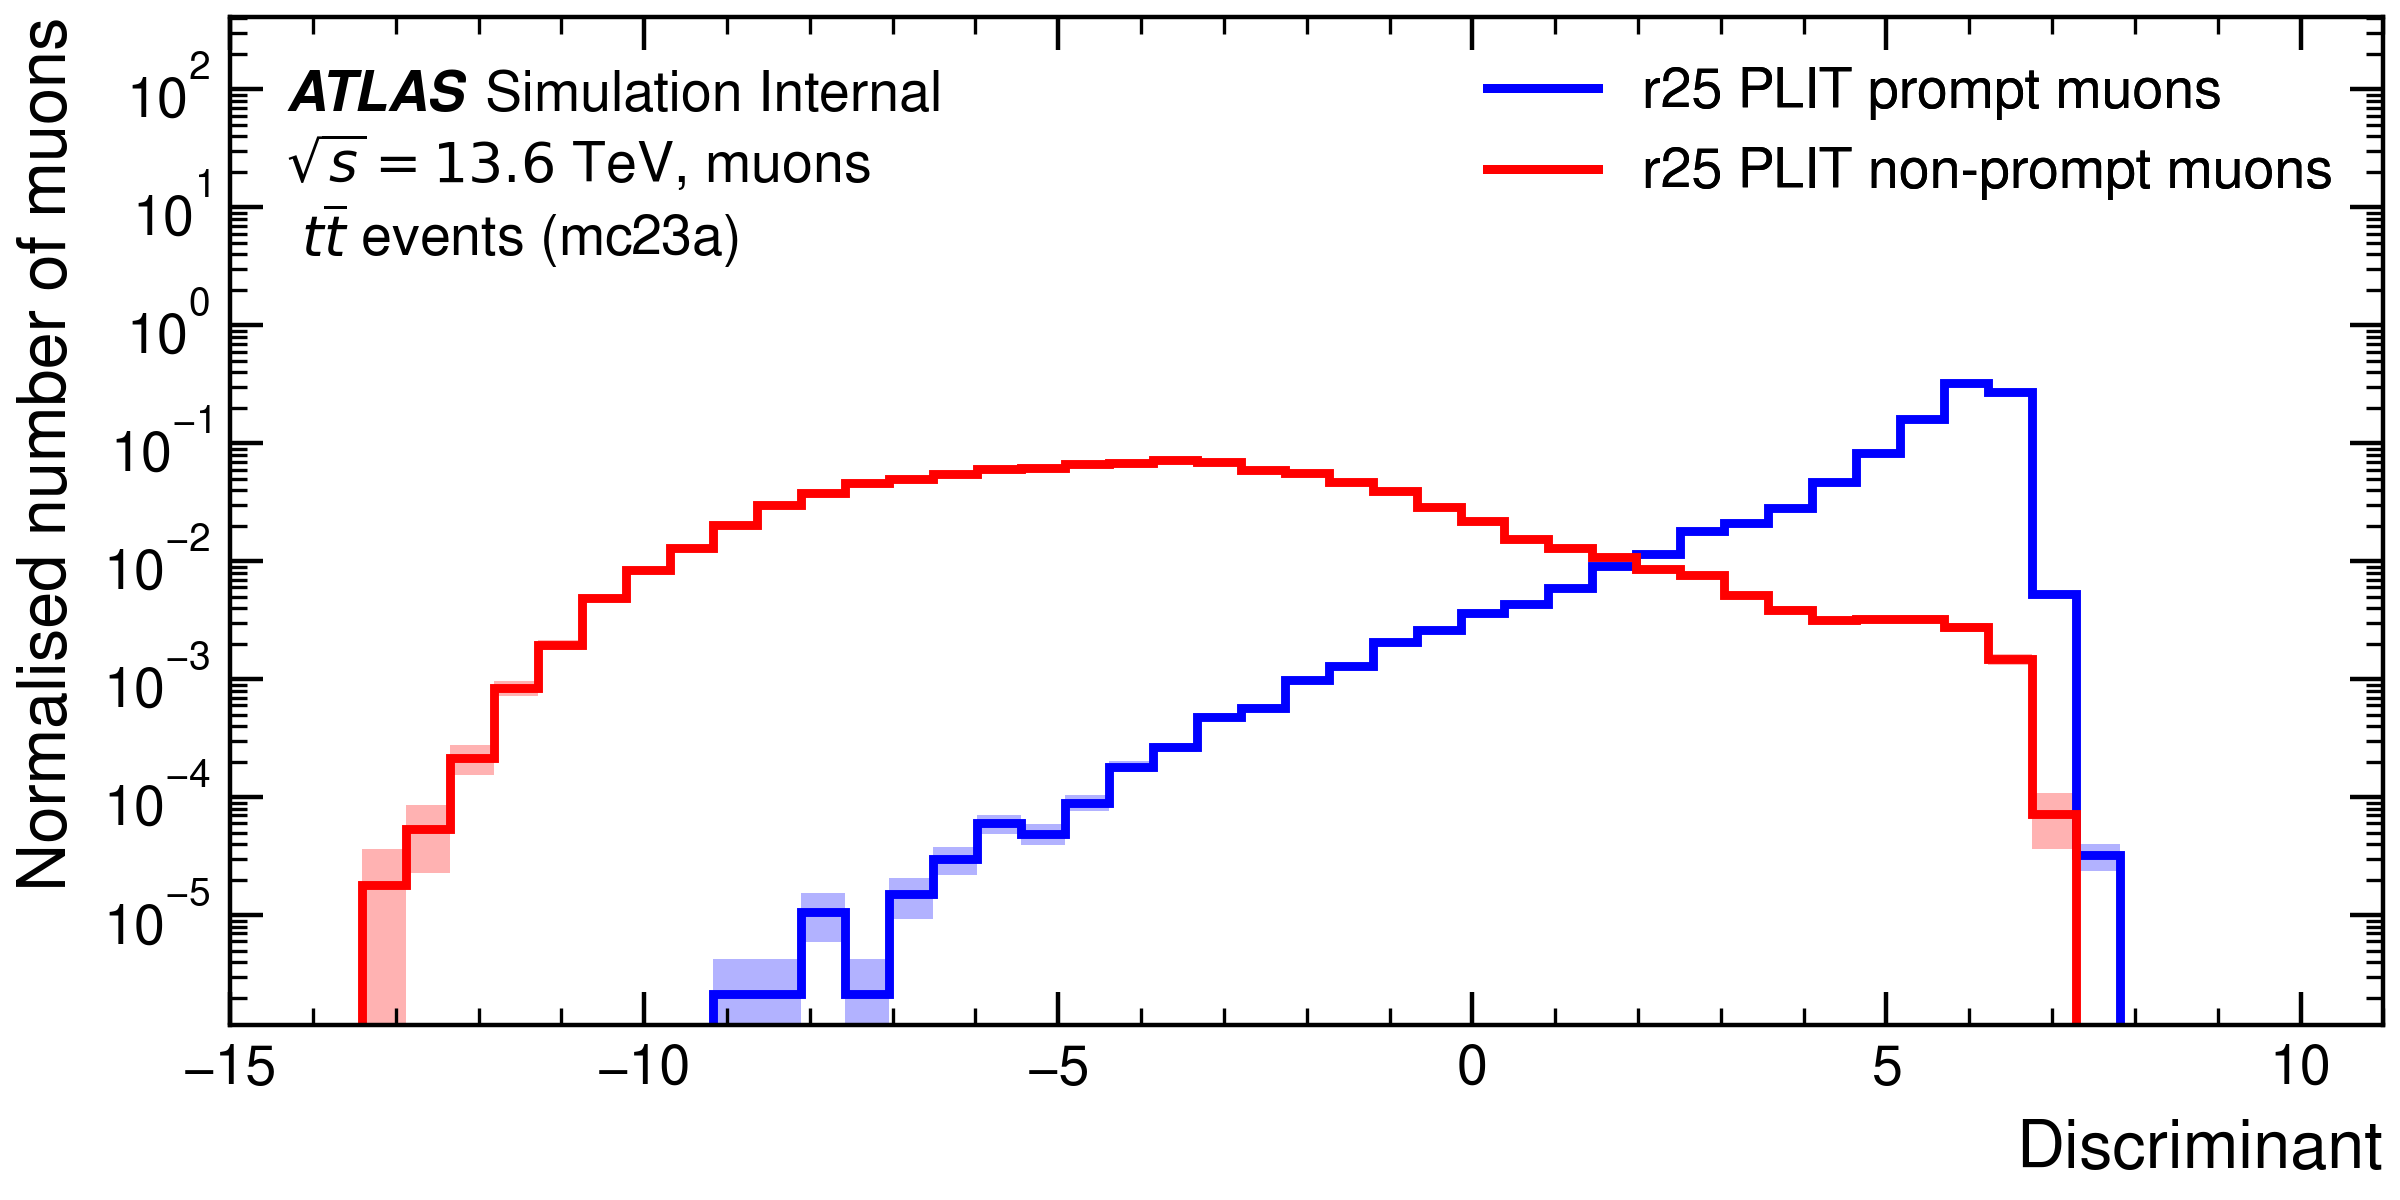

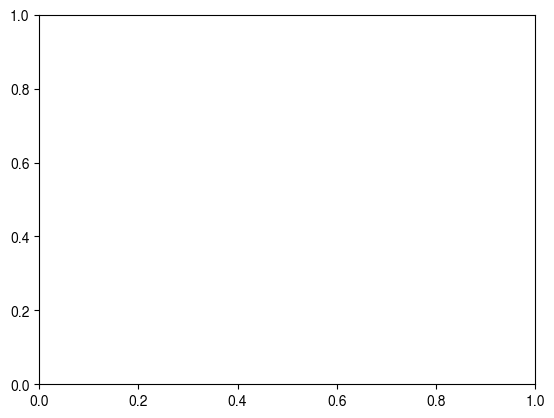

In [71]:
# Calculate discriminant score
df = pd.DataFrame(muons)
df[f"disc_{tagger}"] = np.log(
    df[f"{tagger}_pmuxpromp"] / (df[f"{tagger}_pnpxall"])
)

# defining boolean arrays to select the different flavour classes
is_prompt = df["iffClass"] == 4
is_nonprompt = df["iffClass"] != 4

# Initialise histogram plot
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of muons",
    xlabel=f"Discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-15, 11, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13.6$ TeV, muons\n $t\overline{t}$ events (mc23a)",
)

# Add the histograms
plot_histo.add(
    Histogram(
        df[is_prompt][f"disc_{tagger}"],
        label="r25 PLIT prompt muons",
        colour="blue",
        linestyle="-",
    ),
)
plot_histo.add(
    Histogram(
        df[is_nonprompt][f"disc_{tagger}"],
        label="r25 PLIT non-prompt muons",
        colour="red",
        linestyle="-",
    )
)

plot_histo.draw()
plot_histo.savefig("histogram_discriminant_mc23a_r25_plit_muon.png", transparent=False)
from IPython.display import Image
Image("histogram_discriminant_mc23a_r25_plit_muon.png")

In [ ]:
# use uproot to create root file with discriminant histogram
h_disc_prompt = (
    Hist.new.Reg(50, -15, 11, name="discriminant", label="PLIT discriminant")
    .Double()
)
h_disc_prompt.fill(discriminant=df[is_prompt][f"disc_{tagger}"])
root_file["h_plit_muon_run3_disc_prompt"] = h_disc_prompt.to_numpy()


h_disc_nonprompt = (
    Hist.new.Reg(50, -15, 11, name="discriminant", label="PLIT discriminant")
    .Double()
)
h_disc_nonprompt.fill(discriminant=df[is_nonprompt][f"disc_{tagger}"])
root_file["h_plit_muon_run3_disc_nonprompt"] = h_disc_nonprompt.to_numpy()

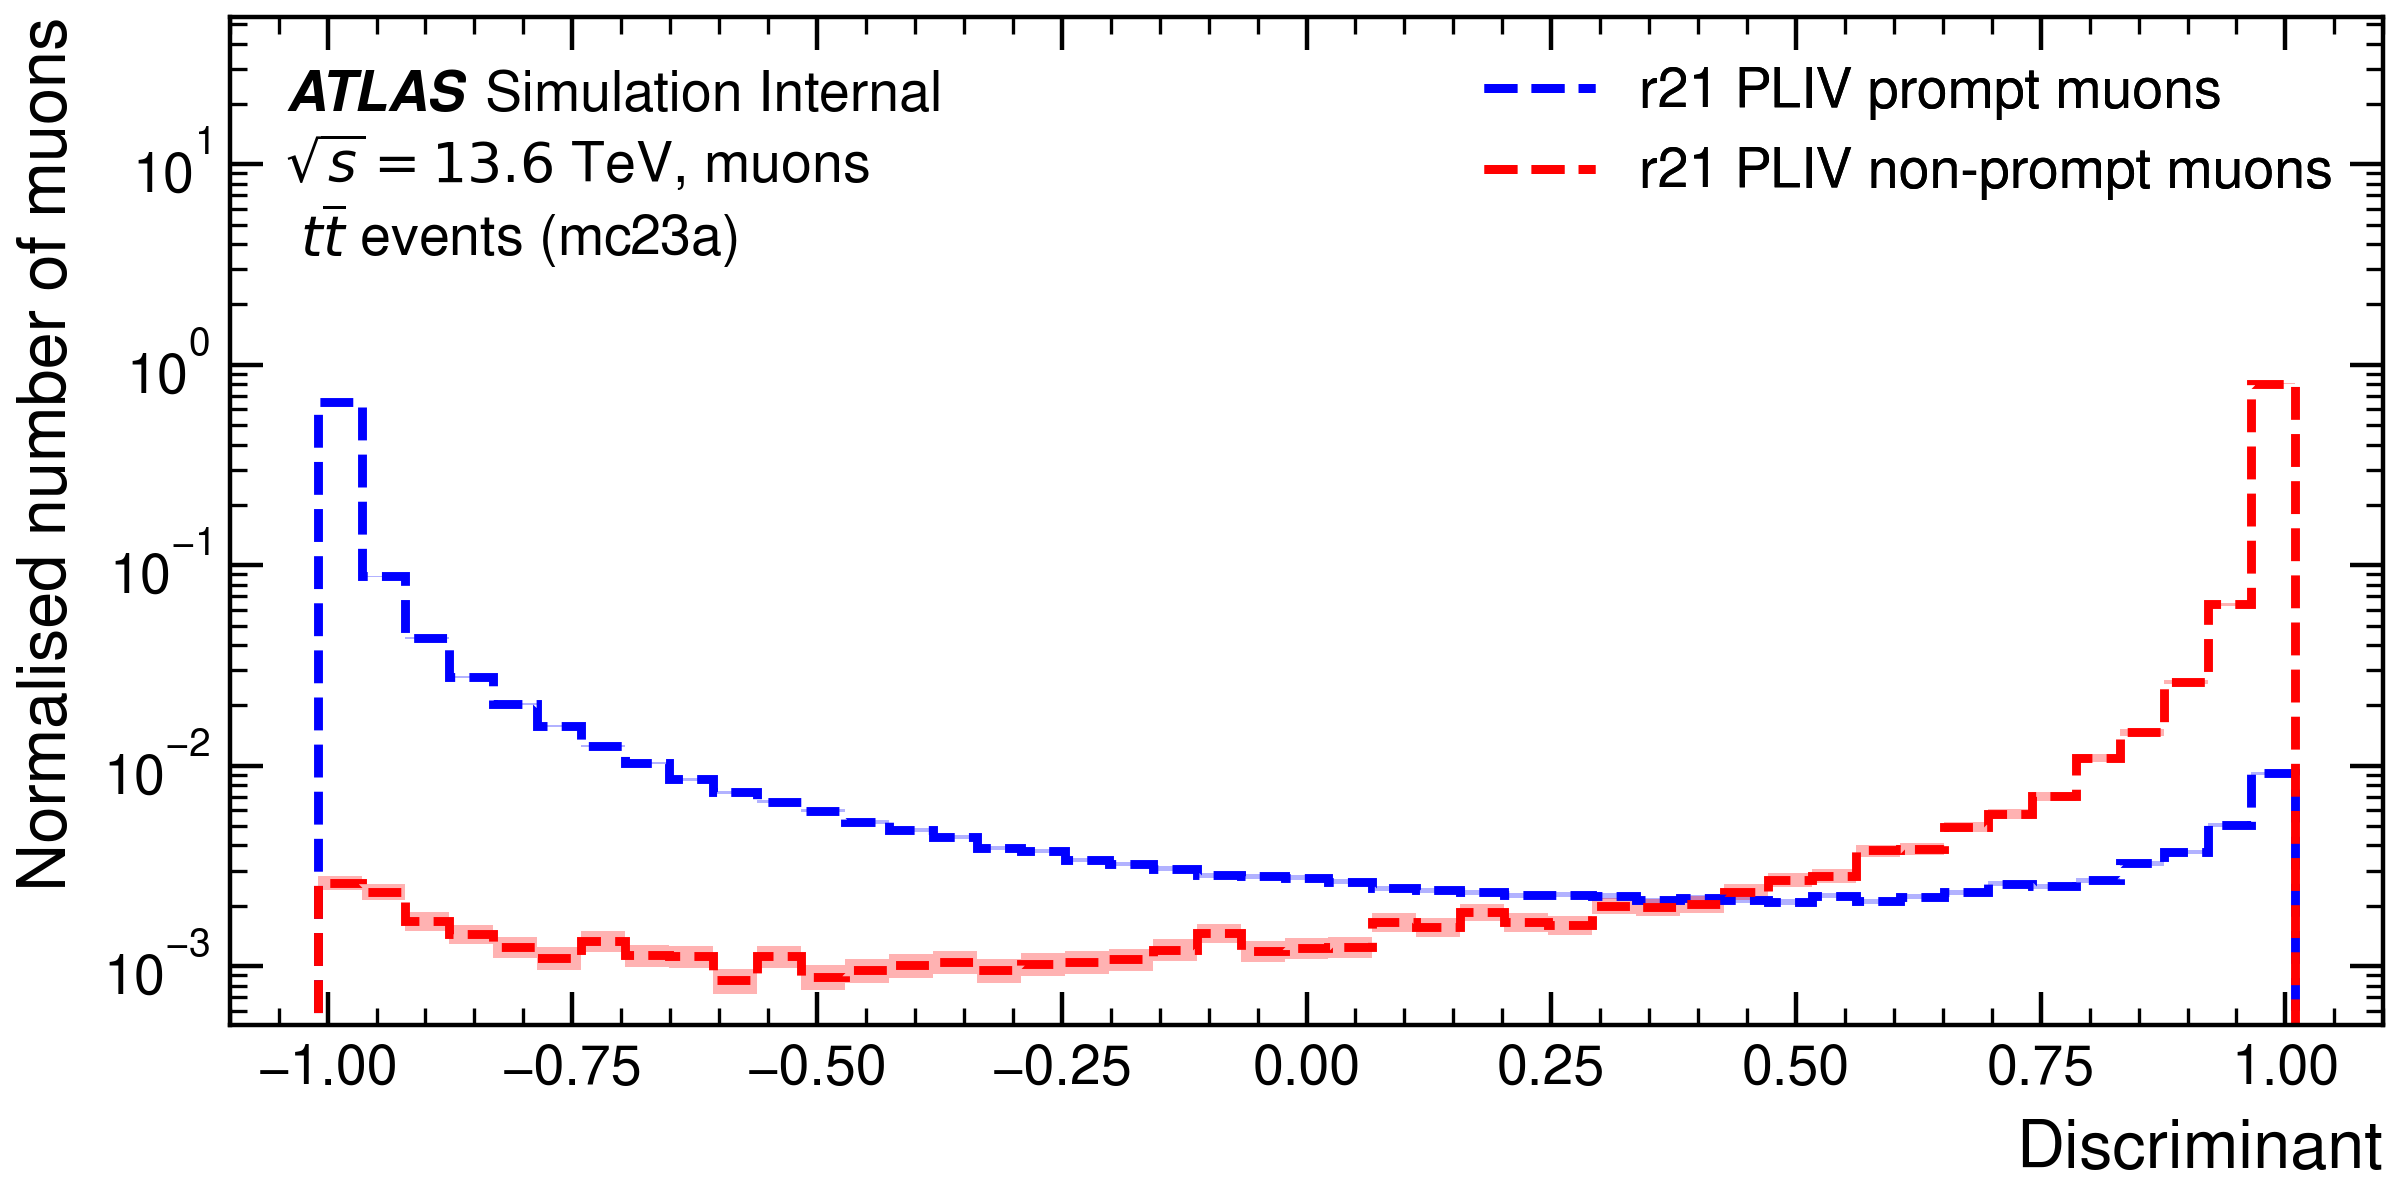

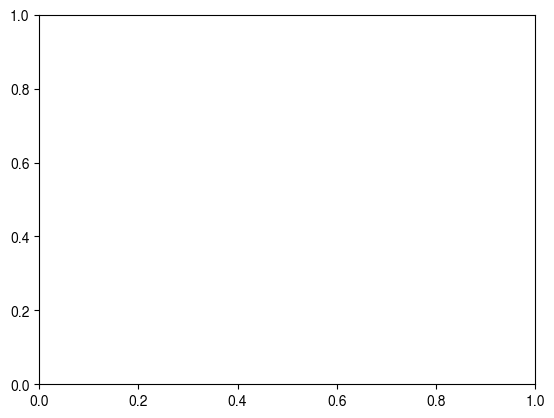

In [72]:
# Calculate discriminant score
df = pd.DataFrame(muons)
df[f"disc_{tagger}"] = np.log(
    df[f"{tagger}_pmuxpromp"] / (df[f"{tagger}_pnpxall"])
)

# defining boolean arrays to select the different flavour classes
is_prompt = df["iffClass"] == 4
is_nonprompt = df["iffClass"] != 4

# Initialise histogram plot
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of muons",
    xlabel=f"Discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-1.1, 1.1, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13.6$ TeV, muons\n $t\overline{t}$ events (mc23a)",
)

# Add the histograms
plot_histo.add(
    Histogram(
        df[is_prompt][tagger_plivr21],
        label="r21 PLIV prompt muons",
        colour="blue",
        linestyle="--",
    ),
)
plot_histo.add(
    Histogram(
        df[is_nonprompt][tagger_plivr21],
        label="r21 PLIV non-prompt muons",
        colour="red",
        linestyle="--",
    )
)

plot_histo.draw()
plot_histo.savefig("histogram_discriminant_mc23a_r21_pliv_muon.png", transparent=False)
from IPython.display import Image
Image("histogram_discriminant_mc23a_r21_pliv_muon.png")

In [ ]:
# use uproot to create root file with discriminant histogram
h_disc_prompt = (
    Hist.new.Reg(50, -1.1, 1.1, name="discriminant", label="PLIV discriminant")
    .Double()
)
h_disc_prompt.fill(discriminant=df[is_prompt][tagger_plivr21])
root_file["h_pliv_muon_run3_disc_prompt"] = h_disc_prompt.to_numpy()


h_disc_nonprompt = (
    Hist.new.Reg(50, -1.1, 1.1, name="discriminant", label="PLIV discriminant")
    .Double()
)
h_disc_nonprompt.fill(discriminant=df[is_prompt][tagger_plivr21])
root_file["h_pliv_muon_run3_disc_nonprompt"] = h_disc_nonprompt.to_numpy()

r25 147.2614639192209


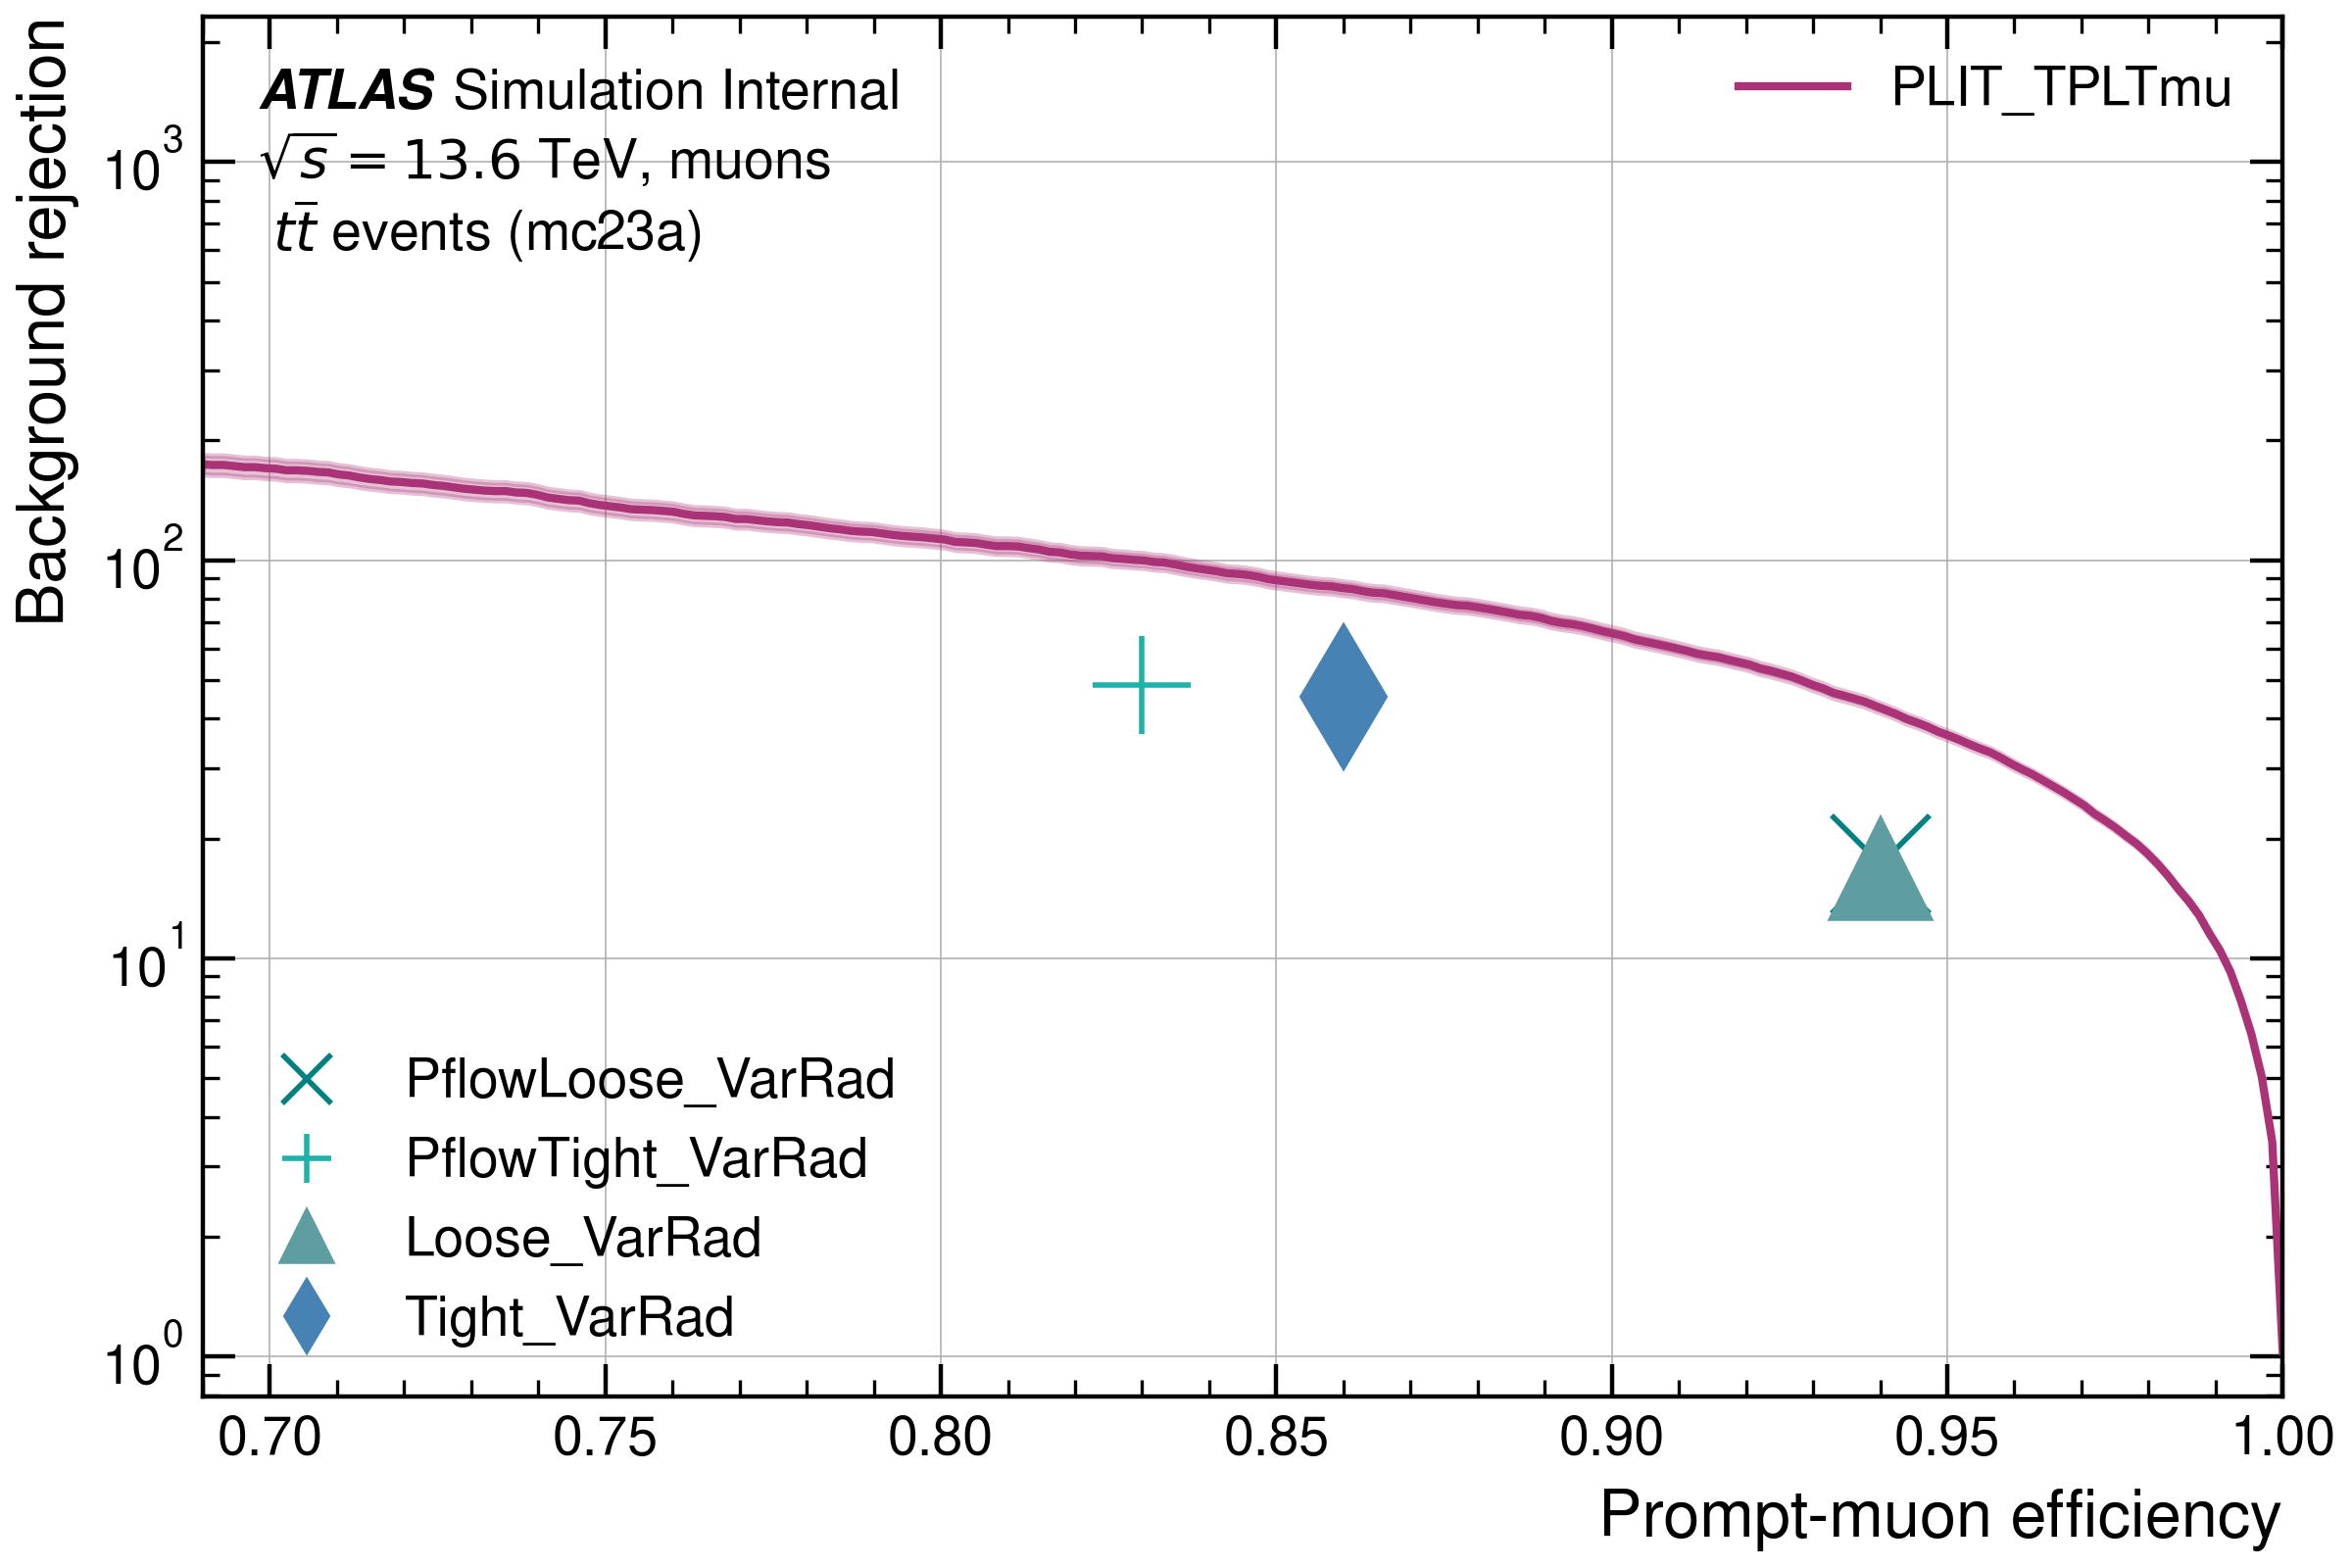

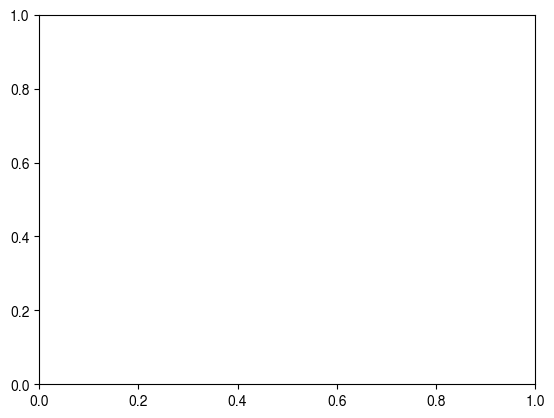

In [75]:
# plot ROC curve
sig_eff = np.linspace(0.69, 1, 200)

n_prompt = sum(is_prompt)
n_nonprompt = sum(is_nonprompt)

# set up ROC plot
plot_roc = RocPlot(
    n_ratio_panels=0,
    ylabel="Background rejection",
    xlabel="Prompt-muon efficiency",
    atlas_second_tag="$\\sqrt{s}=13.6$ TeV, muons\n $t\overline{t}$ events (mc23a)",
    figsize=(6, 4),
    y_scale=1.4,
)

# add r25 PLIT
discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger}_pnpxall", f"{tagger}_pmuxpromp"]].values
)
nonpromptprompt_rej = calc_rej(discs[is_prompt], discs[is_nonprompt], sig_eff)

plot_roc.add_roc(
    Roc(
        sig_eff,
        nonpromptprompt_rej,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label=tagger,
    ),
    reference=True
)
dx = np.diff(1 - nonpromptprompt_rej)  # Differences in x-values
dy = (sig_eff[:-1] + sig_eff[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r25 " + str(auc))

# # add r21 PLIV
# discs_pliv_r21 = df[f"{tagger_plivr21}"].values
# nonpromptprompt_rej_plivr21 = calc_rej(discs_pliv_r21[is_nonprompt], discs_pliv_r21[is_prompt], sig_eff)

# plot_roc.add_roc(
#     Roc(
#         sig_eff,
#         nonpromptprompt_rej_plivr21,
#         n_test=n_nonprompt,
#         rej_class="ujets",
#         signal_class="bjets",
#         label="r21 PLIV",
#     ),
# )
# dx = np.diff(1 - nonpromptprompt_rej_plivr21)  # Differences in x-values
# dy = (sig_eff[:-1] + sig_eff[1:]) / 2  # Average of consecutive y-values
# auc = np.sum(dx * dy)
# print("r21 on mc20 " + str(auc))


# Markers for working points
working_points = [
    "PflowLoose_VarRad",
    "PflowTight_VarRad",
    "Loose_VarRad",
    "Tight_VarRad",
]
markers = ['x', '+', '^', 'd']
colors = ['#008080', '#20B2AA', '#5F9EA0', '#4682B4']

# List to store handles for the markers
handles = []

for wp, marker, color in zip(working_points, markers, colors):
    # Compute fraction of muons surviving this cut and fraction of background muons being rejected
    prompt_efficiency = sum(muons[is_prompt][wp] == 1) / len(muons[is_prompt])
    nonprompt_rejection = len(muons[is_nonprompt]) / sum(muons[is_nonprompt][wp] == 1)  # rejection is inverse of efficiency

    MARKER_X = round(prompt_efficiency, 2)
    MARKER_Y = round(nonprompt_rejection, 1)

    # Plot the working point marker and save the handle
    handle = plot_roc.axis_top.plot(
        MARKER_X, MARKER_Y, marker=marker, markersize=18, color=color, label=wp, linestyle="None"
    )[0]
    
    # Append the handle to the list for custom legend entries
    handles.append(handle)

# Draw the ROC plot
plot_roc.draw()

# Create custom legend using the handles from the working points and add them to the existing puma legend
plot_roc.axis_top.legend(handles=handles, loc="lower left", fontsize=10, markerscale=0.5, frameon=False)


plot_roc.savefig("roc_muon_mc23a_nopliv.png", transparent=False)
from IPython.display import Image
Image("roc_muon_mc23a_nopliv.png")

In [74]:
# compute working points
import numpy as np
import logging
import csv

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logging.getLogger().setLevel(logging.INFO)

def disc_fct(arr: np.ndarray) -> np.ndarray:
    """Tagger discriminant.

    Parameters
    ----------
    arr : numpy.ndarray
        array with shape (2,)

    Returns
    -------
    np.ndarray
        Array with the discriminant values inside.
    """
    return np.log(arr[1] / arr[0])

# Compute discriminants using the appropriate columns
discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger}_pnpxall", f"{tagger}_pmuxpromp"]].values
)

# Obtain cut values for efficiency working points
cut_values = {}
working_points = [0.8, 0.9, 0.95, 0.99]
for eff_wp in working_points:
    # Using discs to calculate the cut values
    d_b_cutvalue = np.quantile(discs, 1.0 - float(eff_wp))
    # Round cut value to 3 decimals
    cut_values[eff_wp] = round(d_b_cutvalue, 3)

# Log the cut values
logger.info("Determined efficiency working point cut values:")
for eff, cut in cut_values.items():
    logger.info(f"Efficiency: {eff} | discriminant cut value: {cut}")

# Write working points to a CSV text file
csv_filename = "working_points_muon_run3.csv"
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Efficiency", "Discriminant Cut Value"])  # Header row
    for eff, cut in cut_values.items():
        writer.writerow([eff, cut])

logger.info(f"Working points have been written to {csv_filename}.")

INFO:__main__:Determined efficiency working point cut values:
INFO:__main__:Efficiency: 0.8 | discriminant cut value: 4.044
INFO:__main__:Efficiency: 0.9 | discriminant cut value: -0.419
INFO:__main__:Efficiency: 0.95 | discriminant cut value: -4.296
INFO:__main__:Efficiency: 0.99 | discriminant cut value: -7.887
INFO:__main__:Working points have been written to working_points_muon_run3.csv.


## Electron Barrel

In [3]:
# fname = "data/2024-02-16/epoch=047-val_loss=0.17304__test_ttbar.h5"
# fname = "data/2024-04-15/barrel/epoch=024-val_loss=0.18271__test_ttbar.h5"
fname = "user.emaricic.41130479._000189.output.h5"
reader = H5Reader(fname, batch_size=100_000, jets_name="electrons")
cuts = Cuts.from_list(["pt > 10e3", "eta < 1.37", "eta > -1.37"])
data = reader.load({"electrons": None}, num_jets=1_500_000)
idx, electrons = cuts(data["electrons"])
tagger_plit = "PLIT_PLITel"
tagger_plivr21 = "PromptLeptonImprovedVetoBARR"

In [29]:
! h5ls -v user.emaricic.41130479._000189.output.h5/electrons


Opened "user.emaricic.41130479._000189.output.h5" with sec2 driver.
electrons                Dataset {335890/Inf}
    Location:  1:800
    Links:     1
    Chunks:    {2048} 323584 bytes
    Storage:   53070620 logical bytes, 34332133 allocated bytes, 154.58% utilization
    Filter-0:  deflate-1 OPT {7}
    Type:      struct {
                   "pt"               +0    native float
                   "eta"              +4    native float
                   "absEta"           +8    native float
                   "phi"              +12   native float
                   "pt_track"         +16   native float
                   "eta_track"        +20   native float
                   "absEta_track"     +24   native float
                   "phi_track"        +28   native float
                   "truth_pt"         +32   native float
                   "truth_eta"        +36   native float
                   "truth_absEta"     +40   native float
                   "truth_phi"        +44   

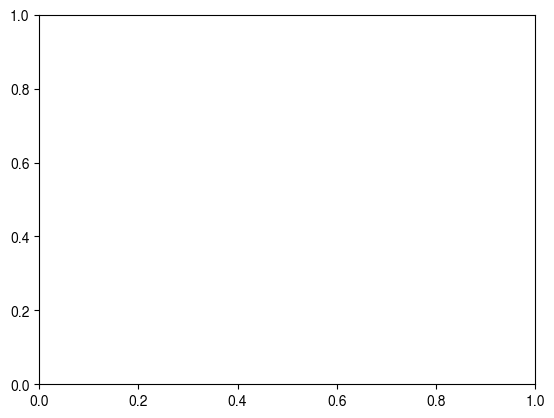

In [6]:
# Calculate discriminant score
df = pd.DataFrame(electrons)

scores_array = np.array([
    df[f"{tagger_plit}_pelxpromp"],
    df[f"{tagger_plit}_pnpxall"]])

df[f"disc_{tagger_plit}"] = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger_plit}_pelxpromp", f"{tagger_plit}_pnpxall"]].values
)

# defining boolean arrays to select the different flavour classes
is_prompt = (df["iffClass"] == 2) | (df["iffClass"] == 3)
is_nonprompt = (df["iffClass"] != 2) & (df["iffClass"] != 3) & (df["iffClass"] != 5)
# is_nonprompt = (df["iffClass"] == 8) | (df["iffClass"] == 9) | (df["iffClass"] == 10)
is_photonconv = df["iffClass"] == 5

taggers = [tagger_plit]
linestyles = get_good_linestyles()[:1]

# Inclusive histogram plot
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of electrons",
    xlabel="Discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 6),
    bins=np.linspace(-10, 10, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13$ TeV + $\\sqrt{s}=13.6$ TeV, electrons\n $t\overline{t}$ events, barrel",
)

plot_histo.add(
    Histogram(
        df[is_prompt][tagger_plivr21],
        label="Prompt electrons (PLIV r21)",
        colour="blue",
        linestyle="--",
    ),
)
plot_histo.add(
    Histogram(
        df[is_nonprompt][tagger_plivr21],
        label="Non-prompt electrons (PLIV r21)",
        colour="red",
        linestyle="--",
    )
)
plot_histo.add(
    Histogram(
        df[is_photonconv][tagger_plivr21],
        label="Photon-conversion electrons (PLIV r21)",
        colour="purple",
        linestyle="--",
    )
)



for tagger, linestyle in zip(taggers, linestyles):
    plot_histo.add(
        Histogram(
            df[is_prompt][f"disc_{tagger}"],
            label="Prompt electrons",
            colour="blue",
            linestyle=linestyle,
        ),
    )
    plot_histo.add(
        Histogram(
            df[is_nonprompt][f"disc_{tagger}"],
            label="Non-prompt electrons",
            colour="red",
            linestyle=linestyle,
        )
    )
    plot_histo.add(
        Histogram(
            df[is_photonconv][f"disc_{tagger}"],
            label="Photon-conversion electrons",
            colour="purple",
            linestyle=linestyle,
        )
    )
plot_histo.draw()
plot_histo.savefig("histogram_discriminant_barrel.png", transparent=False)


# Create histogram plot for non-prompt electron rejection
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of electrons",
    xlabel="Discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-10, 10, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13$ TeV + $\\sqrt{s}=13.6$ TeV, electrons\n $t\overline{t}$ events, barrel",
)
plot_histo.add(
    Histogram(
        df[is_prompt][tagger_plivr21],
        label="Prompt electrons (PLIV r21)",
        colour="blue",
        linestyle="--",
    ),
)
plot_histo.add(
    Histogram(
        df[is_nonprompt][tagger_plivr21],
        label="Non-prompt electrons (PLIV r21)",
        colour="red",
        linestyle="--",
    )
)
for tagger, linestyle in zip(taggers, linestyles):
    plot_histo.add(
        Histogram(
            df[is_prompt][f"disc_{tagger}"],
            label="Prompt electrons",
            colour="blue",
            linestyle=linestyle,
        ),
    )
    plot_histo.add(
        Histogram(
            df[is_nonprompt][f"disc_{tagger}"],
            label="Non-prompt electrons",
            colour="red",
            linestyle=linestyle,
        )
    )
plot_histo.draw()
plot_histo.savefig("histogram_discriminant_barrel_nonprompt.png", transparent=False)


# Create histogram plot for photon-conversion electron rejection
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of electrons",
    xlabel="Discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-10, 10, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13$ TeV + $\\sqrt{s}=13.6$ TeV, electrons\n $t\overline{t}$ events, barrel",
)

plot_histo.add(
    Histogram(
        df[is_prompt][tagger_plivr21],
        label="Prompt electrons (PLIV r21)",
        colour="blue",
        linestyle="--",
    ),
)
plot_histo.add(
    Histogram(
        df[is_photonconv][tagger_plivr21],
        label="Photon-conversion electrons (PLIV r21)",
        colour="red",
        linestyle="--",
    )
)

for tagger, linestyle in zip(taggers, linestyles):
    plot_histo.add(
        Histogram(
            df[is_prompt][f"disc_{tagger}"],
            label="Prompt electrons",
            colour="blue",
            linestyle=linestyle,
        ),
    )
    plot_histo.add(
        Histogram(
            df[is_photonconv][f"disc_{tagger}"],
            label="Photon-conversion electrons",
            colour="red",
            linestyle=linestyle,
        )
    )
plot_histo.draw()
plot_histo.savefig("histogram_discriminant_barrel_photonconv.png", transparent=False)

In [11]:
sig_eff = np.linspace(0.69, 1, 200)
n_prompt = sum(is_prompt)
n_nonprompt = sum(is_nonprompt)
n_photonconv = sum(is_photonconv)
n_all = len(df)

# ROC for non-prompt electron rejection
epsilon_s = np.array([0.7003876 , 0.71589147, 0.73255814, 0.75193798, 0.76821705,
       0.78527132, 0.80193798, 0.81744186, 0.83255814, 0.84806202,
       0.86434109, 0.87868217, 0.89069767, 0.90503876, 0.91627907,
       0.93100775, 0.94496124, 0.95775194, 0.96976744, 0.97945736,
       0.9875969 , 0.99457364, 0.99806202, 1.        ]
)
epsilon_b = np.array([300.45385302, 271.22725793, 238.65897869, 202.09499382,
       182.43623926, 156.47481417, 130.81774743, 113.64636664,
        91.43471407,  78.42317924,  66.40827851,  54.11695265,
        45.8259114 ,  36.40081531,  30.8239924 ,  23.86589787,
        18.24362393,  13.76857165,  10.        ,   6.98947321,
         4.82317848,   2.81838293,   1.75567629,   1.        ]
)
sig_eff = epsilon_s

discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger_plit}_pelxpromp", f"{tagger_plit}_pnpxall"]].values
)

discs_pliv_r21 = df[f"{tagger_plivr21}"].values

nonpromptprompt_rej = calc_rej(discs[is_prompt], discs[is_nonprompt], sig_eff)
nonpromptprompt_rej_plivr21 = calc_rej(discs_pliv_r21[is_prompt], discs_pliv_r21[is_nonprompt], sig_eff)


HighPtCaloOnly 0.9154008468299772 2.5661661661661666
Loose_VarRad 0.9501683878090021 5.681737588652482
Tight_VarRad 0.8071062916020365 17.02257636122178
TightTrackOnly_VarRad 0.9329429903625345 6.383466135458168
TightTrackOnly_FixedRad 0.9286110218321898 6.5800821355236145
r21 240.3841995616821
r24 45.22287013646494
HighPtCaloOnly 0.9154008468299772 1.3407407407407408
Loose_VarRad 0.9501683878090021 1.514644351464435
Tight_VarRad 0.8071062916020365 2.3205128205128203
TightTrackOnly_VarRad 0.9329429903625345 1.4715447154471544
TightTrackOnly_FixedRad 0.9286110218321898 1.4897119341563785
r21 77.91710197393449
r24 16.82000889146373


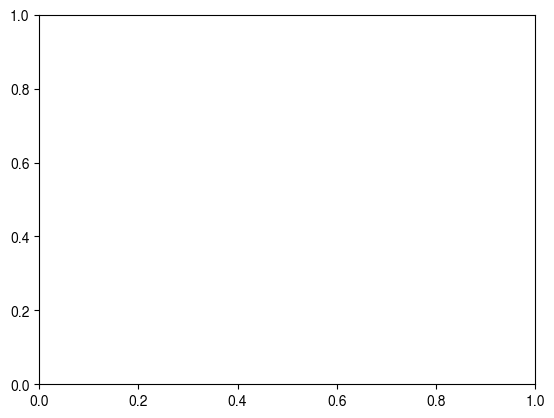

In [17]:
sig_eff = np.linspace(0.69, 1, 200)
n_prompt = sum(is_prompt)
n_nonprompt = sum(is_nonprompt)
n_photonconv = sum(is_photonconv)
n_all = len(df)

# ROC for non-prompt electron rejection
epsilon_s = np.array([0.7003876 , 0.71589147, 0.73255814, 0.75193798, 0.76821705,
       0.78527132, 0.80193798, 0.81744186, 0.83255814, 0.84806202,
       0.86434109, 0.87868217, 0.89069767, 0.90503876, 0.91627907,
       0.93100775, 0.94496124, 0.95775194, 0.96976744, 0.97945736,
       0.9875969 , 0.99457364, 0.99806202, 1.        ]
)
epsilon_b = np.array([300.45385302, 271.22725793, 238.65897869, 202.09499382,
       182.43623926, 156.47481417, 130.81774743, 113.64636664,
        91.43471407,  78.42317924,  66.40827851,  54.11695265,
        45.8259114 ,  36.40081531,  30.8239924 ,  23.86589787,
        18.24362393,  13.76857165,  10.        ,   6.98947321,
         4.82317848,   2.81838293,   1.75567629,   1.        ]
)
sig_eff = epsilon_s

discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger_plit}_pnpxall", f"{tagger_plit}_pelxpromp", ]].values
)

discs_pliv_r21 = df[f"{tagger_plivr21}"].values

nonpromptprompt_rej = calc_rej(discs[is_prompt], discs[is_nonprompt], sig_eff)
nonpromptprompt_rej_plivr21 = calc_rej(discs_pliv_r21[is_nonprompt], discs_pliv_r21[is_prompt], sig_eff)


plot_roc = RocPlot(
    n_ratio_panels=0,
    ylabel="Background rejection",
    xlabel="Prompt-electron efficiency",
    atlas_second_tag="$\\sqrt{s}=13$ TeV + $\\sqrt{s}=13.6$ TeV, electrons\n $t\overline{t}$ events, barrel",
    figsize=(6, 4),
    y_scale=1.4,
)
plot_roc.add_roc(
    Roc(
        epsilon_s,
        epsilon_b,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label="PLIV r21",
        colour="red"
    ),
    reference=True
)
plot_roc.add_roc(
    Roc(
        sig_eff,
        nonpromptprompt_rej,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label=tagger_plit,
    ),
)

plot_roc.add_roc(
    Roc(
        sig_eff,
        nonpromptprompt_rej_plivr21,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label=tagger_plivr21,
    ),
)

official_wps = ['HighPtCaloOnly', 'Loose_VarRad', 'Tight_VarRad', 'TightTrackOnly_VarRad', 'TightTrackOnly_FixedRad']
colors = ['blue', 'purple', 'orange', 'pink', 'brown']
markers = ['x', '+', '1', '2', '3']

for wp, color, marker in zip(official_wps, colors, markers):
    eff_prompt = sum(df[is_prompt][wp]) / n_prompt
    rej_nonprompt = 1./ (sum(df[is_nonprompt][wp]) / n_nonprompt)
    print(wp, eff_prompt, rej_nonprompt)

    # Marker
    MARKER_X = eff_prompt
    MARKER_Y = rej_nonprompt
    p = plot_roc.axis_top.plot(MARKER_X, MARKER_Y, marker, markersize=14, color=color, label=wp)



dx = np.diff(1 - epsilon_b)  # Differences in x-values
dy = (epsilon_s[:-1] + epsilon_s[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r21 " + str(auc))

dx = np.diff(1 - nonpromptprompt_rej)  # Differences in x-values
dy = (sig_eff[:-1] + sig_eff[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r24 " + str(auc))

# plot_roc.set_ratio_class(1, "ujets")
plot_roc.draw()
plot_roc.savefig("roc_barrel_nonprompt.png", transparent=False)


# ROC for photon-conversion electron rejection
epsilon_s = np.array([0.7       , 0.70974026, 0.72649351, 0.73584416, 0.74831169,
       0.76467532, 0.78337662, 0.79896104, 0.81493506, 0.82818182,
       0.84727273, 0.86051948, 0.87181818, 0.88935065, 0.90649351,
       0.92480519, 0.94428571, 0.96532468, 0.97974026, 0.99298701,
       1.]
)
epsilon_b = np.array([101.08689006,  87.83386058,  72.30276894,  68.49845109,
        58.87800033,  46.41588834,  38.20846798,  31.11413606,
        25.61242527,  21.31270127,  18.12241045,  15.08008383,
        13.10300456,  10.32962385,   8.05570004,   5.88780003,
         4.16599083,   2.88465511,   2.0410759 ,   1.45988703,
         1.        ]
)
sig_eff = epsilon_s

discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger_plit}_pnpxall", f"{tagger_plit}_pelxpromp", ]].values
)

discs_pliv_r21 = df[f"{tagger_plivr21}"].values


photonconv_rej = calc_rej(discs[is_prompt], discs[is_photonconv], sig_eff)
photonconv_rej_plivr21 = calc_rej(discs_pliv_r21[is_photonconv], discs_pliv_r21[is_prompt], sig_eff)


plot_roc = RocPlot(
    n_ratio_panels=0,
    ylabel="Photon-conv. rejection",
    xlabel="Prompt-electron efficiency",
    atlas_second_tag="$\\sqrt{s}=13$ TeV + $\\sqrt{s}=13.6$ TeV, electrons\n $t\overline{t}$ events, barrel",
    figsize=(6, 4),
    y_scale=1.4,
)
# plot_roc.add_roc(
#     Roc(
#         epsilon_s,
#         epsilon_b,
#         n_test=n_photonconv,
#         rej_class="ujets",
#         signal_class="bjets",
#         label="PLIV r21",
#         colour="red"
#     ),
#     reference=True
# )
plot_roc.add_roc(
    Roc(
        sig_eff,
        photonconv_rej,
        n_test=n_photonconv,
        rej_class="ujets",
        signal_class="bjets",
        label=tagger_plit,
    ),
)
plot_roc.add_roc(
    Roc(
        sig_eff,
        photonconv_rej_plivr21,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label=tagger_plivr21,
    ),
)

official_wps = ['HighPtCaloOnly', 'Loose_VarRad', 'Tight_VarRad', 'TightTrackOnly_VarRad', 'TightTrackOnly_FixedRad']
colors = ['blue', 'purple', 'orange', 'pink', 'brown']
markers = ['x', '+', '1', '2', '3']
for wp, color, marker in zip(official_wps, colors, markers):
    eff_prompt = sum(df[is_prompt][wp]) / n_prompt
    rej_photonconv = 1./ (sum(df[is_photonconv][wp]) / n_photonconv)
    print(wp, eff_prompt, rej_photonconv)
    
    # Marker
    MARKER_X = eff_prompt
    MARKER_Y = rej_photonconv
    plot_roc.axis_top.plot(MARKER_X, MARKER_Y, marker, markersize=14, color=color, label=wp)


dx = np.diff(1 - epsilon_b)  # Differences in x-values
dy = (epsilon_s[:-1] + epsilon_s[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r21 " + str(auc))

dx = np.diff(1 - photonconv_rej)  # Differences in x-values
dy = (sig_eff[:-1] + sig_eff[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r24 " + str(auc))

# plot_roc.set_ratio_class(1, "ujets")
plot_roc.draw()
plot_roc.savefig("roc_barrel_photonconv.png", transparent=False)

## Electron Endcap

In [18]:
fname = "data/2024-04-15/endcap/epoch=020-val_loss=0.17197__test_ttbar.h5"
reader = H5Reader(fname, batch_size=100_000, jets_name="electrons")
cuts = Cuts.from_list(["pt > 10e3", "absEta > 1.52"])
data = reader.load({"electrons": None}, num_jets=500_000)
idx, electrons = cuts(data["electrons"])
tagger = "PLITel"

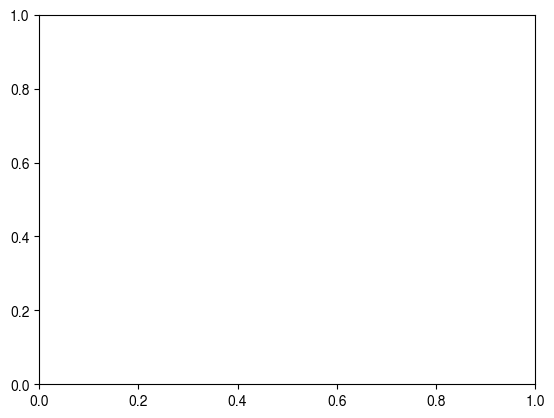

In [19]:
# Calculate discriminant score
df = pd.DataFrame(electrons)
df[f"disc_{tagger}"] = np.log(
    df[f"{tagger}_pelxprompt"] / (df[f"{tagger}_pnpxall"])
)

is_prompt = (df["iffClass"] == 2) | (df["iffClass"] == 3)
is_nonprompt = (df["iffClass"] != 2) & (df["iffClass"] != 3) & (df["iffClass"] != 5)
# is_nonprompt = (df["iffClass"] == 8) | (df["iffClass"] == 9) | (df["iffClass"] == 10)
is_photonconv = df["iffClass"] == 5

taggers = [tagger]
linestyles = get_good_linestyles()[:1]


# Create histogram plot for end-cap
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of electrons",
    xlabel=f"{tagger} discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-10, 10, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13$ TeV + $\\sqrt{s}=13.6$ TeV, electrons\n $t\overline{t}$ events, endcap",
)
for tagger, linestyle in zip(taggers, linestyles):
    plot_histo.add(
        Histogram(
            df[is_prompt][f"disc_{tagger}"],
            label="Prompt electrons",
            colour="blue",
            linestyle=linestyle,
        ),
    )
    plot_histo.add(
        Histogram(
            df[is_nonprompt][f"disc_{tagger}"],
            label="Non-prompt electrons",
            colour="red",
            linestyle=linestyle,
        )
    )
    plot_histo.add(
        Histogram(
            df[is_photonconv][f"disc_{tagger}"],
            label="Photon-conversion electrons",
            colour="purple",
            linestyle=linestyle,
        )
    )
plot_histo.draw()
plot_histo.savefig("histogram_discriminant_endcap.png", transparent=False)


# Create histogram plot for non-prompt electron rejection
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of electrons",
    xlabel=f"{tagger} discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-10, 10, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13$ TeV, electrons\n $t\overline{t}$ events, endcap",
)
for tagger, linestyle in zip(taggers, linestyles):
    plot_histo.add(
        Histogram(
            df[is_prompt][f"disc_{tagger}"],
            label="Prompt electrons",
            colour="blue",
            linestyle=linestyle,
        ),
    )
    plot_histo.add(
        Histogram(
            df[is_nonprompt][f"disc_{tagger}"],
            label="Non-prompt electrons",
            colour="red",
            linestyle=linestyle,
        )
    )
plot_histo.draw()
plot_histo.savefig("histogram_discriminant_endcap_nonprompt.png", transparent=False)


# Create histogram plot for photon-conversion electron rejection
plot_histo = HistogramPlot(
    n_ratio_panels=0,
    ylabel="Normalised number of electrons",
    xlabel=f"{tagger} discriminant",
    logy=True,
    leg_ncol=1,
    figsize=(6, 3),
    bins=np.linspace(-10, 10, 50),
    y_scale=1.5,
    atlas_second_tag="$\\sqrt{s}=13$ TeV + $\\sqrt{s}=13.6$ TeV, electrons\n $t\overline{t}$ events, endcap",
)
for tagger, linestyle in zip(taggers, linestyles):
    plot_histo.add(
        Histogram(
            df[is_prompt][f"disc_{tagger}"],
            label="Prompt electrons",
            colour="blue",
            linestyle=linestyle,
        ),
    )
    plot_histo.add(
        Histogram(
            df[is_photonconv][f"disc_{tagger}"],
            label="Photon-conversion electrons",
            colour="red",
            linestyle=linestyle,
        )
    )
plot_histo.draw()
plot_histo.savefig("histogram_discriminant_endcap_photonconv.png", transparent=False)

HighPtCaloOnly 0.9414552487812603 2.4325913481730366
Loose_VarRad 0.952042166698714 4.757289527720739
Tight_VarRad 0.816900611914807 14.663291139240508
TightTrackOnly_VarRad 0.9196253859813824 4.857023060796646
TightTrackOnly_FixedRad 0.9165488457318659 5.008214440121055
r21 91.84881276928591
r24 123.78138152922789
HighPtCaloOnly 0.9414552487812603 1.2208436724565757
Loose_VarRad 0.952042166698714 1.3050397877984086
Tight_VarRad 0.816900611914807 1.7697841726618704
TightTrackOnly_VarRad 0.9196253859813824 1.413793103448276
TightTrackOnly_FixedRad 0.9165488457318659 1.4513274336283186
r21 23.212497736070755
r24 13.903658284739672


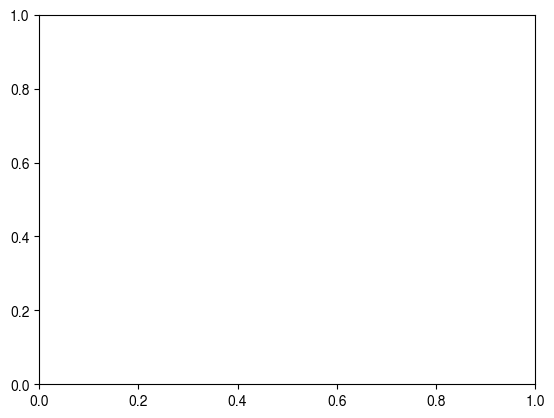

In [12]:
sig_eff = np.linspace(0.69, 1, 200)
n_prompt = sum(is_prompt)
n_nonprompt = sum(is_nonprompt)
n_photonconv = sum(is_photonconv)

# ROC for non-prompt electron rejection
epsilon_s = np.array([0.56764296, 0.58549512, 0.61059972, 0.64128312, 0.66917713,
       0.70041841, 0.72775453, 0.76290098, 0.79191074, 0.8237099 ,
       0.85216179, 0.88675035, 0.91576011, 0.94086471, 0.95760112,
       0.97545328, 0.9888424 , 0.99553696, 1.]
)
epsilon_b = np.array([117.96966195, 111.64695683, 108.01717701, 105.66312357,
        97.8206675 ,  89.56804811,  80.22435242,  68.00422337,
        56.38923103,  45.73904381,  37.51134872,  25.79189509,
        18.32980711,  12.0597891 ,   8.47675566,   5.51603222,
         3.25058646,   2.00186786,   1.       ]
)
sig_eff = epsilon_s

discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger}_pnpxall", f"{tagger}_pelxprompt"]].values
)
nonpromptprompt_rej = calc_rej(discs[is_prompt], discs[is_nonprompt], sig_eff)

plot_roc = RocPlot(
    n_ratio_panels=0,
    ylabel="Background rejection",
    xlabel="Prompt-electron efficiency",
    atlas_second_tag="$\\sqrt{s}=13$ TeV + $\\sqrt{s}=13.6$ TeV, electrons\n $t\overline{t}$ events, endcap",
    figsize=(6, 4),
    y_scale=1.4,
)
# plot_roc.add_roc(
#     Roc(
#         epsilon_s,
#         epsilon_b,
#         n_test=n_nonprompt,
#         rej_class="ujets",
#         signal_class="bjets",
#         label="PLIV r21",
#         colour="red"
#     ),
#     reference=True
# )
plot_roc.add_roc(
    Roc(
        sig_eff,
        nonpromptprompt_rej,
        n_test=n_nonprompt,
        rej_class="ujets",
        signal_class="bjets",
        label=tagger,
    ),
)

official_wps = ['HighPtCaloOnly', 'Loose_VarRad', 'Tight_VarRad', 'TightTrackOnly_VarRad', 'TightTrackOnly_FixedRad']
colors = ['blue', 'purple', 'orange', 'pink', 'brown']
markers = ['x', '+', '1', '2', '3']
for wp, color, marker in zip(official_wps, colors, markers):
    eff_prompt = sum(df[is_prompt][wp]) / n_prompt
    rej_nonprompt = 1./ (sum(df[is_nonprompt][wp]) / n_nonprompt)
    print(wp, eff_prompt, rej_nonprompt)
    
    # Marker
    MARKER_X = eff_prompt
    MARKER_Y = rej_nonprompt
    plot_roc.axis_top.plot(MARKER_X, MARKER_Y, marker, markersize=14, color=color, label=wp)

dx = np.diff(1 - epsilon_b)  # Differences in x-values
dy = (epsilon_s[:-1] + epsilon_s[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r21 " + str(auc))

dx = np.diff(1 - nonpromptprompt_rej)  # Differences in x-values
dy = (sig_eff[:-1] + sig_eff[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r24 " + str(auc))

# plot_roc.set_ratio_class(1, "ujets")
plot_roc.draw()
plot_roc.savefig("roc_endcap_nonprompt.png", transparent=False)





# ROC for photon-conversion electron rejection
epsilon_s = np.array([0.56875872, 0.57991632, 0.5916318 , 0.60502092, 0.62008368,
       0.64686192, 0.66917713, 0.69483961, 0.71994421, 0.73054393,
       0.75788006, 0.77573222, 0.79358438, 0.81589958, 0.83542538,
       0.85829847, 0.87670851, 0.89679219, 0.92133891, 0.94142259,
       0.96317992, 0.9776848 , 0.99107392, 1.]
)
epsilon_b = np.array([33.33502333, 30.79992212, 28.9622342 , 26.75968002, 25.16305453,
       22.24990927, 19.50187354, 17.24412734, 14.85100093, 13.96491086,
       11.61142433, 10.26716122,  8.92034558,  7.61516625,  6.73355288,
        5.64817829,  5.08284505,  4.33914917,  3.39261323,  2.92178904,
        2.28443406,  1.85001638,  1.40881823,  1.]
)
sig_eff = epsilon_s

discs = np.apply_along_axis(
    disc_fct, 1, df[[f"{tagger}_pnpxall", f"{tagger}_pelxprompt"]].values
)
photonconv_rej = calc_rej(discs[is_prompt], discs[is_photonconv], sig_eff)

plot_roc = RocPlot(
    n_ratio_panels=0,
    ylabel="Photon-conv. rejection",
    xlabel="Prompt-electron efficiency",
    atlas_second_tag="$\\sqrt{s}=13$ TeV + $\\sqrt{s}=13.6$ TeV, electrons\n $t\overline{t}$ events, endcap",
    figsize=(6, 4),
    y_scale=1.4,
)
# plot_roc.add_roc(
#     Roc(
#         epsilon_s,
#         epsilon_b,
#         n_test=n_photonconv,
#         rej_class="ujets",
#         signal_class="bjets",
#         label="PLIV r21",
#         colour="red"
#     ),
#     reference=True
# )
plot_roc.add_roc(
    Roc(
        sig_eff,
        photonconv_rej,
        n_test=n_photonconv,
        rej_class="ujets",
        signal_class="bjets",
        label=tagger,
    ),
)

official_wps = ['HighPtCaloOnly', 'Loose_VarRad', 'Tight_VarRad', 'TightTrackOnly_VarRad', 'TightTrackOnly_FixedRad']
colors = ['blue', 'purple', 'orange', 'pink', 'brown']
markers = ['x', '+', '1', '2', '3']
for wp, color, marker in zip(official_wps, colors, markers):
    eff_prompt = sum(df[is_prompt][wp]) / n_prompt
    rej_photonconv = 1./ (sum(df[is_photonconv][wp]) / n_photonconv)
    print(wp, eff_prompt, rej_photonconv)
    
    # Marker
    MARKER_X = eff_prompt
    MARKER_Y = rej_nonprompt
    plot_roc.axis_top.plot(MARKER_X, MARKER_Y, marker, markersize=14, color=color, label=wp)

dx = np.diff(1 - epsilon_b)  # Differences in x-values
dy = (epsilon_s[:-1] + epsilon_s[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r21 " + str(auc))

dx = np.diff(1 - photonconv_rej)  # Differences in x-values
dy = (sig_eff[:-1] + sig_eff[1:]) / 2  # Average of consecutive y-values
auc = np.sum(dx * dy)
print("r24 " + str(auc))

# plot_roc.set_ratio_class(1, "ujets")
plot_roc.draw()
plot_roc.savefig("roc_endcap_photonconv.png", transparent=False)
